# <span style="color:turquoise">**Detección de defectos en células utilizando Fast-RCNN**</span>

## **Hardware**

**PC** Lenovo Idealpad Gaming3

**Procesador** AMD Ryzen 5 5600H with Radeon Graphics 3.3 GHz

	Velocidad de base:	3,30 GHz
	Sockets:	1
	Núcleos:	6
	Procesadores lógicos:	12
	Virtualización:	Habilitado
	Caché L1:	384 kB
	Caché L2:	3,0 MB
	Caché L3:	16,0 MB

**Gráficos dedicados** NVIDIA GeForce RTX 3050 Laptop 

	Versión del controlador:	31.0.15.5176
	Fecha del controlador:	01/03/2024
	Versión de DirectX:	12 (FL 12.1)
	Memoria de GPU dedicada	4,0 GB
	Memoria de GPU compartida	7,7 GB
	Memoria de GPU	11,7 GB
	
**RAM** 16 GB SODIMM DDR4 

	Velocidad:	3200 MHz
	Ranuras usadas:	2 de 2
	Factor de forma:	SODIMM

**Memoria estado sólido** SSD 512 GB 2210 NVMe PCIe Gen3 x4  Micron MTFDHBA512QFD

**Google Colab** 
	12.7 GB RAM, 15 GB RAM GPU Tesla T4, SSD 78.2 GB

## **Introducción**

https://pytorch.org/vision/0.11/models.html

## **Dependencias**

In [1]:
# !pip install pycocotools

In [1]:
import os 
import numpy as np
import torch, torchvision, inspect, gc
import matplotlib.pyplot as plt
import torchvision.models.detection as detection_models
import torch.optim as optim
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from torchvision.datasets import CocoDetection
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn, FasterRCNN_MobileNet_V3_Large_FPN_Weights
from torchvision.transforms import functional as F
from torchvision.utils import draw_bounding_boxes
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score

## **Entrenamiento de Fast-RCNN**

In [3]:
!nvidia-smi

Thu May  1 18:26:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.02                 Driver Version: 576.02         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P0              6W /   60W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
print("PyTorch ha sido importado con éxito.")
print(f"Versión de PyTorch: {torch.__version__}")
print(f"¿CUDA está disponible? {torch.cuda.is_available()}")
print(f"Versión de CUDA: {torch.version.cuda}")
print(f"Dispositivo CUDA: {torch.cuda.get_device_name(0)}")
device = torch.device("cuda:0")

PyTorch ha sido importado con éxito.
Versión de PyTorch: 2.6.0+cu126
¿CUDA está disponible? True
Versión de CUDA: 12.6
Dispositivo CUDA: NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
faster_models = [name for name, func in inspect.getmembers(detection_models) 
                if inspect.isfunction(func) and name.startswith("faster")]
print("Modelos disponibles:", faster_models)

Modelos disponibles: ['fasterrcnn_mobilenet_v3_large_320_fpn', 'fasterrcnn_mobilenet_v3_large_fpn', 'fasterrcnn_resnet50_fpn', 'fasterrcnn_resnet50_fpn_v2']


In [ ]:
# import torchvision.transforms as T

# class CocoWrapper(CocoDetection):
#     def __init__(self, root, annFile, target_size=(1280, 1024)):
#         super().__init__(root, annFile)
#         self.target_size = target_size  # (width, height)
        
#     def __getitem__(self, idx):
#         # Convertir cualquier tipo de índice a int de Python
#         idx = int(idx)
        
#         img, annots = super().__getitem__(idx)
        
#         # Guardar tamaño original
#         original_width, original_height = img.size
        
#         # Redimensionar imagen a 1280x1024
#         img = img.resize(self.target_size, Image.LANCZOS)
        
#         # Convertir a tensor
#         img = F.to_tensor(img)
        
#         # Calcular factores de escala
#         scale_x = self.target_size[0] / original_width  # 1280 / original_width
#         scale_y = self.target_size[1] / original_height  # 1024 / original_height
        
#         boxes = []
#         labels = []
#         for o in annots:
#             x, y, w, h = o['bbox']
            
#             # Escalar bounding boxes al nuevo tamaño
#             x_scaled = x * scale_x
#             y_scaled = y * scale_y
#             w_scaled = w * scale_x
#             h_scaled = h * scale_y
            
#             # Convertir a [xmin, ymin, xmax, ymax]
#             boxes.append([x_scaled, y_scaled, x_scaled + w_scaled, y_scaled + h_scaled])
#             labels.append(o['category_id'])
            
#         target = {
#             'boxes': torch.tensor(boxes, dtype=torch.float32),
#             'labels': torch.tensor(labels, dtype=torch.int64)
#         }
#         return img, target

def collate_fn(batch):
    return tuple(zip(*batch))

class CocoWrapper(CocoDetection):
    def __getitem__(self, idx):
        img, annots = super().__getitem__(idx)
        img = F.to_tensor(img)
        boxes = []
        labels = []
        for o in annots:
            x, y, w, h = o['bbox']           # COCO bbox
            # convertir a [xmin, ymin, xmax, ymax]
            boxes.append([x, y, x + w, y + h])
            labels.append(o['category_id'])
        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64)
        }
        return img, target

# Base de los datasets
BASE = Path(r"..\03.Datasets")

# Train
train_imgs = str(BASE/"YOLO_Datasets"/"split"/"train"/"images")
train_ann  = str(BASE/"COCO_Datasets"/"train.json")
train_ds = CocoWrapper(root=train_imgs, annFile=train_ann, transforms=None)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, collate_fn=collate_fn)

# Validación
val_imgs = str(BASE/"YOLO_Datasets"/"split"/"val"/"images")
val_ann  = str(BASE/"COCO_Datasets"/"val.json")
val_ds   = CocoWrapper(root=val_imgs, annFile=val_ann, transforms=None)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Test
test_imgs = str(BASE/"YOLO_Datasets"/"test"/"images")
test_ann  = str(BASE/"COCO_Datasets"/"test.json")
test_ds   = CocoWrapper(root=test_imgs, annFile=test_ann, transforms=None)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Usar CocoWrapper modificado con tamaño fijo
# train_ds = CocoWrapper(root=train_imgs, annFile=train_ann, target_size=(1280, 1024))
# val_ds   = CocoWrapper(root=val_imgs, annFile=val_ann, target_size=(1280, 1024))
# test_ds  = CocoWrapper(root=test_imgs, annFile=test_ann, target_size=(1280, 1024))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# CLASS_NAMES=["background", "defectCell"]

# # ----------------------------------------------------------------------------------------------------
# weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
# model = fasterrcnn_resnet50_fpn_v2(weights=weights)  

# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(CLASS_NAMES))
# # ----------------------------------------------------------------------------------------------------
# # weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
# # model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)

# # in_features = model.roi_heads.box_predictor.cls_score.in_features
# # model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(CLASS_NAMES))
# # ----------------------------------------------------------------------------------------------------
# # weights = FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT
# # model = fasterrcnn_mobilenet_v3_large_fpn(weights=weights)

# # in_features = model.roi_heads.box_predictor.cls_score.in_features
# # model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(CLASS_NAMES))
# # ----------------------------------------------------------------------------------------------------

# try:
#     model.to(device)
#     print("Model successfully moved to device.")
# except RuntimeError as e:
#     print(f"Error moving model to device: {e}")

# # optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)
# # optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.7, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Model successfully moved to device.


-------------------------------------------------------------------------------------------------------------------------------------

In [10]:
class EarlyStopping:
    """Clase para implementar early stopping durante el entrenamiento"""
    
    def __init__(self, patience=3, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
            return True
            
        if score > self.best_score + self.delta:
            self.best_score = score
            self.counter = 0
            return True
        else:
            self.counter += 1
            self.early_stop = self.counter >= self.patience
            return False


class MetricsCalculator:
    """Clase para calcular métricas basadas en TP, FP, FN con IoU para detección de objetos"""
    
    @staticmethod
    def calculate_detection_metrics_with_iou(pred_boxes, pred_labels, pred_scores, 
                                           true_boxes, true_labels, 
                                           confidence_threshold=0.7, iou_threshold=0.5, target_class=1):
        """
        Calcular métricas de detección basadas en TP, FP, FN usando IoU
        Incluye cálculo de mAP@50
        """
        # Filtrar predicciones por confianza
        keep = pred_scores > confidence_threshold
        pred_boxes_filtered = pred_boxes[keep]
        pred_labels_filtered = pred_labels[keep]
        pred_scores_filtered = pred_scores[keep]
        
        # Inicializar contadores
        tp = 0
        fp = 0
        fn = 0
        ious_list = []
        
        # Filtrar ground truth para la clase objetivo
        target_mask = true_labels == target_class
        target_boxes = true_boxes[target_mask]
        target_labels = true_labels[target_mask]
        
        # Filtrar predicciones para la clase objetivo
        pred_target_mask = pred_labels_filtered == target_class
        pred_target_boxes = pred_boxes_filtered[pred_target_mask]
        pred_target_labels = pred_labels_filtered[pred_target_mask]
        pred_target_scores = pred_scores_filtered[pred_target_mask]
        
        # **NUEVO: Calcular mAP@50**
        map50 = MetricsCalculator._calculate_map50(
            pred_target_boxes, pred_target_scores, target_boxes
        )
        
        # Procesar cada ground truth individualmente
        for gt_box, gt_label in zip(target_boxes, target_labels):
            gt_label_item = gt_label.item()
            
            if len(pred_target_boxes) == 0:
                fn += 1
                continue
            
            ious = torchvision.ops.box_iou(gt_box.unsqueeze(0), pred_target_boxes)
            
            if ious.numel() == 0:
                fn += 1
                continue
            
            max_iou, max_idx = ious.max(dim=1)
            pred_label = pred_target_labels[max_idx].item() if len(pred_target_labels) > 0 else 0
            
            if max_iou.item() > iou_threshold:
                if gt_label_item == target_class:
                    tp += 1
                    ious_list.append(max_iou.item())
            else:
                fn += 1
        
        # Contar False Positives
        used_predictions = set()
        for gt_box in target_boxes:
            if len(pred_target_boxes) == 0:
                continue
                
            ious = torchvision.ops.box_iou(gt_box.unsqueeze(0), pred_target_boxes)
            if ious.numel() > 0:
                max_iou, max_idx = ious.max(dim=1)
                if max_iou.item() > iou_threshold:
                    used_predictions.add(max_idx.item())
        
        fp = len(pred_target_boxes) - len(used_predictions)
        
        # Calcular métricas
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        avg_iou = np.mean(ious_list) if ious_list else 0.0
        
        return {
            'TP': int(tp),
            'FP': int(fp),
            'FN': int(fn),
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'avg_iou': avg_iou,
            'map50': map50,  # **NUEVA MÉTRICA**
            'total_gt_objects': len(target_boxes),
            'total_predictions': len(pred_target_boxes),
            'confidence_threshold': confidence_threshold,
            'iou_threshold': iou_threshold
        }
    
    @staticmethod
    def _calculate_map50(pred_boxes, pred_scores, gt_boxes, iou_threshold=0.5):
        """
        Calcular mAP@50 (Average Precision at IoU=0.5)
        
        Args:
            pred_boxes: Tensor con cajas predichas
            pred_scores: Tensor con scores de confianza
            gt_boxes: Tensor con cajas verdaderas
            iou_threshold: Umbral de IoU (0.5 para mAP@50)
        
        Returns:
            float: Valor de mAP@50
        """
        if len(pred_boxes) == 0 or len(gt_boxes) == 0:
            return 0.0
        
        # Ordenar predicciones por score descendente
        sorted_indices = torch.argsort(pred_scores, descending=True)
        pred_boxes_sorted = pred_boxes[sorted_indices]
        pred_scores_sorted = pred_scores[sorted_indices]
        
        # Inicializar arrays para precision y recall
        tp = torch.zeros(len(pred_boxes_sorted))
        fp = torch.zeros(len(pred_boxes_sorted))
        
        # Marcar GT boxes como detectadas o no
        gt_detected = torch.zeros(len(gt_boxes), dtype=torch.bool)
        
        # Para cada predicción
        for i, (pred_box, pred_score) in enumerate(zip(pred_boxes_sorted, pred_scores_sorted)):
            # Calcular IoU con todos los GT boxes
            ious = torchvision.ops.box_iou(pred_box.unsqueeze(0), gt_boxes).squeeze(0)
            
            # Encontrar el mejor match
            max_iou, max_idx = torch.max(ious, dim=0)
            
            if max_iou >= iou_threshold and not gt_detected[max_idx]:
                tp[i] = 1
                gt_detected[max_idx] = True
            else:
                fp[i] = 1
        
        # Calcular precision y recall acumulados
        tp_cumsum = torch.cumsum(tp, dim=0)
        fp_cumsum = torch.cumsum(fp, dim=0)
        
        recalls = tp_cumsum / len(gt_boxes)
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-8)
        
        # Calcular Average Precision usando interpolación
        ap = MetricsCalculator._compute_ap(recalls.numpy(), precisions.numpy())
        
        return ap
    
    @staticmethod
    def _compute_ap(recalls, precisions):
        """
        Calcular Average Precision usando interpolación de 11 puntos
        """
        # Añadir puntos (0,1) y (1,0) para completar la curva
        recalls = np.concatenate(([0.0], recalls, [1.0]))
        precisions = np.concatenate(([0.0], precisions, [0.0]))
        
        # Interpolación monótona
        for i in range(len(precisions) - 2, -1, -1):
            precisions[i] = max(precisions[i], precisions[i + 1])
        
        # Calcular AP usando interpolación de 11 puntos
        recall_thresholds = np.linspace(0, 1, 11)
        ap = 0.0
        
        for threshold in recall_thresholds:
            # Encontrar la precisión interpolada para este recall
            indices = recalls >= threshold
            if np.any(indices):
                ap += np.max(precisions[indices])
        
        return ap / 11.0
    
    @staticmethod
    def calculate_batch_metrics(all_pred_boxes, all_pred_labels, all_pred_scores,
                              all_true_boxes, all_true_labels,
                              confidence_threshold=0.7, iou_threshold=0.5, target_class=1):
        """
        Calcular métricas para un lote completo de imágenes incluyendo mAP@50
        """
        total_tp = 0
        total_fp = 0
        total_fn = 0
        all_ious = []
        all_map50s = []  # **NUEVO**
        total_gt = 0
        total_preds = 0
        
        for pred_boxes, pred_labels, pred_scores, true_boxes, true_labels in zip(
            all_pred_boxes, all_pred_labels, all_pred_scores, all_true_boxes, all_true_labels):
            
            metrics = MetricsCalculator.calculate_detection_metrics_with_iou(
                pred_boxes, pred_labels, pred_scores, true_boxes, true_labels,
                confidence_threshold, iou_threshold, target_class
            )
            
            total_tp += metrics['TP']
            total_fp += metrics['FP']
            total_fn += metrics['FN']
            total_gt += metrics['total_gt_objects']
            total_preds += metrics['total_predictions']
            
            if metrics['avg_iou'] > 0:
                all_ious.append(metrics['avg_iou'])
            
            # **NUEVO: Acumular mAP@50**
            all_map50s.append(metrics['map50'])
        
        # Calcular métricas globales
        precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
        recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        avg_iou = np.mean(all_ious) if all_ious else 0.0
        avg_map50 = np.mean(all_map50s) if all_map50s else 0.0  # **NUEVO**
        
        return {
            'TP': total_tp,
            'FP': total_fp,
            'FN': total_fn,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'avg_iou': avg_iou,
            'map50': avg_map50,  # **NUEVA MÉTRICA**
            'total_gt_objects': total_gt,
            'total_predictions': total_preds,
            'confidence_threshold': confidence_threshold,
            'iou_threshold': iou_threshold
        }
    
    @staticmethod
    def print_detection_metrics(metrics_dict, class_name="defectCell"):
        """Imprimir métricas de detección incluyendo mAP@50"""
        print(f"\n{'='*60}")
        print(f"MÉTRICAS DE DETECCIÓN - {class_name.upper()}")
        print(f"{'='*60}")
        print(f"True Positives (TP):     {metrics_dict['TP']}")
        print(f"False Positives (FP):    {metrics_dict['FP']}")
        print(f"False Negatives (FN):    {metrics_dict['FN']}")
        print(f"{'-'*60}")
        print(f"Precision:               {metrics_dict['precision']:.4f}")
        print(f"Recall:                  {metrics_dict['recall']:.4f}")
        print(f"F1-Score:                {metrics_dict['f1_score']:.4f}")
        print(f"IoU Promedio:            {metrics_dict['avg_iou']:.4f}")
        print(f"mAP@50:                  {metrics_dict['map50']:.4f}")  # **NUEVO**
        print(f"{'-'*60}")
        print(f"Total objetos GT:        {metrics_dict['total_gt_objects']}")
        print(f"Total predicciones:      {metrics_dict['total_predictions']}")
        print(f"Umbral confianza:        {metrics_dict['confidence_threshold']}")
        print(f"Umbral IoU:              {metrics_dict['iou_threshold']}")
        print(f"{'='*60}")


class MetricsPlotter:
    """Clase para visualizar métricas de entrenamiento y evaluación (sin matrices de confusión)"""
    
    @staticmethod
    def plot_training_metrics(train_losses, val_f1_scores, val_ious=None):
        """Graficar métricas de entrenamiento (Loss, F1-Score e IoU)"""
        epochs = range(1, len(train_losses)+1)
        
        if val_ious is not None:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
        else:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Training Loss
        ax1.plot(epochs, train_losses, marker='o', color='blue', linewidth=2)
        ax1.set_title("Training Loss per Epoch", fontsize=14, fontweight='bold')
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss")
        ax1.grid(True, alpha=0.3)
        
        # F1-Score
        ax2.plot(epochs, val_f1_scores, marker='o', color='red', linewidth=2)
        ax2.set_title("Validation F1-Score per Epoch", fontsize=14, fontweight='bold')
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("F1-Score")
        ax2.set_ylim(0, 1.0)
        ax2.grid(True, alpha=0.3)
        
        # IoU (si está disponible)
        if val_ious is not None:
            ax3.plot(epochs, val_ious, marker='o', color='green', linewidth=2)
            ax3.set_title("Validation IoU per Epoch", fontsize=14, fontweight='bold')
            ax3.set_xlabel("Epoch")
            ax3.set_ylabel("IoU")
            ax3.set_ylim(0, 1.0)
            ax3.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_detection_metrics(tp, fp, fn, avg_iou=None, class_name="defectCell"):
        """Graficar métricas de detección sin IoU"""
        # **CAMBIO: Siempre usar solo 2 subplots**
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Gráfico de barras con TP, FP, FN
        categories = ['True\nPositives', 'False\nPositives', 'False\nNegatives']
        values = [tp, fp, fn]
        colors = ["#008CFF", "#00FFDD", "#FFA200"]  
        
        bars = ax1.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
        ax1.set_title(f'Métricas de Detección - {class_name}', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Número de Casos', fontsize=12)
        
        # Añadir valores en las barras
        for bar, value in zip(bars, values):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.02, 
                    str(value), ha='center', va='bottom', fontweight='bold', fontsize=12)
        
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Gráfico circular (solo si hay valores)
        if tp + fp + fn > 0:
            sizes = [tp, fp, fn]
            labels = [f'TP: {tp}', f'FP: {fp}', f'FN: {fn}']
            explode = (0.1, 0, 0)  # Destacar TP
            
            wedges, texts, autotexts = ax2.pie(sizes, labels=labels, colors=colors, 
                                              autopct='%1.1f%%', startangle=90, explode=explode)
            ax2.set_title(f'Distribución de Detecciones - {class_name}', 
                         fontsize=14, fontweight='bold')
            
            # Mejorar texto
            for autotext in autotexts:
                autotext.set_color('white')
                autotext.set_fontweight('bold')
        else:
            ax2.text(0.5, 0.5, 'No hay datos\npara mostrar', 
                    ha='center', va='center', transform=ax2.transAxes, fontsize=12)
            ax2.set_title('Sin datos')
        
        # **ELIMINADO: El tercer gráfico de IoU**
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_precision_recall_f1_iou_map50(precision, recall, f1, iou, map50):
        """Graficar métricas principales incluyendo mAP@50"""
        metrics = ['Precision', 'Recall', 'F1-Score', 'IoU', 'mAP@50']
        values = [precision, recall, f1, iou, map50]
        colors = ["#1faab4", "#0eff4e", "#f6e20a", '#9932CC', "#ff0000"]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Gráfico de barras
        bars = ax1.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
        ax1.set_title('Métricas de Rendimiento (incluyendo mAP@50)', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Valor', fontsize=12)
        ax1.set_ylim(0, 1)
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Rotar etiquetas del eje x para mejor legibilidad
        ax1.set_xticks(range(len(metrics)))
        ax1.set_xticklabels(metrics, rotation=45, ha='right')
        
        # Añadir valores en las barras
        for bar, value in zip(bars, values):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        # Gráfico radial (tipo spider)
        angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
        values_radar = values + [values[0]]
        angles += angles[:1]
        
        ax2 = plt.subplot(122, projection='polar')
        ax2.plot(angles, values_radar, 'o-', linewidth=2, color='#2ca02c')
        ax2.fill(angles, values_radar, alpha=0.25, color="#9cff9c")
        ax2.set_xticks(angles[:-1])
        ax2.set_xticklabels(metrics)
        ax2.set_ylim(0, 1)
        ax2.set_title('Vista Radial de Métricas (con mAP@50)', fontsize=14, fontweight='bold', pad=20)
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()


class FastRCNNTrainer:
    """Clase para entrenar y evaluar modelos Fast-RCNN con métricas basadas en IoU"""
    
    def __init__(self, class_names, device, model_save_dir="./Fast_RCNN_models"):
        self.class_names = class_names
        self.device = device
        self.model_save_dir = model_save_dir
        self.metrics_calculator = MetricsCalculator()
        self.metrics_plotter = MetricsPlotter()
        os.makedirs(self.model_save_dir, exist_ok=True)
        
    def create_model(self, model_type='resnet50_fpn_v2'):
        """Crear modelo Fast-RCNN"""
        if model_type == 'resnet50_fpn_v2':
            weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
            model = fasterrcnn_resnet50_fpn_v2(weights=weights)
        elif model_type == 'resnet50_fpn':
            weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
            model = fasterrcnn_resnet50_fpn(weights=weights)
        elif model_type == 'mobilenet_v3':
            weights = FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT
            model = fasterrcnn_mobilenet_v3_large_fpn(weights=weights)
        else:
            raise ValueError(f"Tipo de modelo no soportado: {model_type}")
            
        # Modificar la cabeza de clasificación
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(self.class_names))
        
        model.to(self.device)
        return model
    
    def create_optimizer(self, model, optimizer_type='sgd', learning_rate=0.001, momentum=0.7, weight_decay=0.0005):
        """Crear optimizador"""
        if optimizer_type == 'sgd':
            return optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
        elif optimizer_type == 'adam':
            return optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        elif optimizer_type == 'adamw':
            return optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        else:
            raise ValueError(f"Tipo de optimizador no soportado: {optimizer_type}")
    
    def evaluate_model(self, model, val_loader, confidence_threshold=0.7, iou_threshold=0.8):
        """Evaluar el modelo usando métricas TP, FP, FN con IoU"""
        model.eval()
        
        all_pred_boxes = []
        all_pred_labels = []
        all_pred_scores = []
        all_true_boxes = []
        all_true_labels = []
        
        with torch.no_grad():
            for images, targets in tqdm(val_loader, desc="Evaluating"):
                if not images or not targets:
                    continue
                
                images = [img.to(self.device) for img in images]
                targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
                outputs = model(images)
                
                for output, target in zip(outputs, targets):
                    all_pred_boxes.append(output['boxes'].cpu())
                    all_pred_labels.append(output['labels'].cpu())
                    all_pred_scores.append(output['scores'].cpu())
                    all_true_boxes.append(target['boxes'].cpu())
                    all_true_labels.append(target['labels'].cpu())
        
        # Calcular métricas usando IoU
        metrics = self.metrics_calculator.calculate_batch_metrics(
            all_pred_boxes, all_pred_labels, all_pred_scores,
            all_true_boxes, all_true_labels,
            confidence_threshold, iou_threshold, target_class=1
        )
        
        # Mostrar métricas
        self.metrics_calculator.print_detection_metrics(metrics, "defectCell")
        
        # Visualizar métricas
        self.metrics_plotter.plot_detection_metrics(
            metrics['TP'], metrics['FP'], metrics['FN'], metrics['avg_iou'], "defectCell"
        )
        self.metrics_plotter.plot_precision_recall_f1_iou_map50(
            metrics['precision'], metrics['recall'], metrics['f1_score'], metrics['avg_iou'], metrics['map50']
        )
    
        return metrics['f1_score'], metrics
    
    def train_model(self, model, optimizer, lr_scheduler, num_epochs, train_loader, val_loader, 
                   confidence_threshold=0.7, iou_threshold=0.5, patience=3, delta=0.01):
        """Entrenar el modelo usando métricas TP, FP, FN con IoU"""
        early_stopping = EarlyStopping(patience=patience, delta=delta)
        train_losses = []
        val_f1_scores = []
        val_ious = []
        
        for epoch in range(num_epochs):
            print("="*80)
            model.train()
            total_loss = 0.0
            
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
            
            for images, targets in progress_bar:
                if images is None or targets is None:
                    continue
                
                images = list(img.to(self.device) for img in images)
                targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
                
                loss_dict = model(images, targets)
                loss = sum(loss for loss in loss_dict.values())
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                progress_bar.set_postfix(loss=loss.item())
                
                del loss_dict, loss
                torch.cuda.empty_cache()
                gc.collect()
            
            lr_scheduler.step()
            avg_loss = total_loss / len(train_loader)
            train_losses.append(avg_loss)
            print(f"Training Loss: {avg_loss:.4f}")
            
            # Evaluación usando métricas TP, FP, FN con IoU
            f1_score, metrics = self.evaluate_model(
                model, val_loader, confidence_threshold, iou_threshold
            )
            val_f1_scores.append(f1_score)
            val_ious.append(metrics['avg_iou'])
            
            # Early stopping basado en F1-Score
            improved = early_stopping(f1_score)
            if early_stopping.early_stop:
                print(f"Early stopping triggered. Best F1: {early_stopping.best_score:.4f}")
                break
            elif improved:
                print(f"Model improved. New best F1: {f1_score:.4f}")
                torch.save(model.state_dict(), os.path.join(self.model_save_dir, "best_model.pth"))
            else:
                print(f"No improvement in F1. Patience: {early_stopping.counter}/{early_stopping.patience}")
        
        # Mostrar gráficos de entrenamiento
        self.metrics_plotter.plot_training_metrics(train_losses, val_f1_scores, val_ious)
    
    def print_final_results(self, metrics, title="RESULTADOS FINALES"):
        """Mostrar resultados finales del modelo de forma elegante"""
        print("\n" + "="*60)
        print(f"🎯 {title}")
        print("="*60)
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {metrics['f1_score']:.4f}")
        print(f"IoU Promedio: {metrics['avg_iou']:.4f}")
        
        # Calcular accuracy
        tp = metrics['TP']
        fp = metrics['FP']
        fn = metrics['FN']
        accuracy = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"\nTrue Positives: {metrics['TP']}")
        print(f"False Positives: {metrics['FP']}")
        print(f"False Negatives: {metrics['FN']}")
        print(f"\nTotal Predicciones: {metrics['total_predictions']}")
        print(f"Total Ground Truth: {metrics['total_gt_objects']}")
        print(f"Umbral Confianza: {metrics['confidence_threshold']}")
        print(f"Umbral IoU: {metrics['iou_threshold']}")
        print("="*60)
        
        return metrics
    
    def evaluate_test(self, test_loader, test_dataset, weights_model, confidence_threshold=0.7, 
                     iou_threshold=0.5, save_images=False, output_path="./test_results"):
        """Evaluar en conjunto de test"""
        if save_images:
            os.makedirs(output_path, exist_ok=True)
            print(f"Guardando imágenes en: {output_path}")
        
        # Cargar modelo
        weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
        model = fasterrcnn_resnet50_fpn_v2(weights=weights)
        
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(self.class_names))
        
        try:
            model.load_state_dict(torch.load(weights_model))
            print("Modelo cargado correctamente")
        except Exception as e:
            print(f"Error al cargar el modelo: {e}")
            return
        
        model.to(self.device)
        model.eval()
        
        all_pred_boxes = []
        all_pred_labels = []
        all_pred_scores = []
        all_true_boxes = []
        all_true_labels = []
        
        with torch.no_grad():
            for batch_idx, (images, targets) in enumerate(tqdm(test_loader, desc="Evaluando test")):
                if not images or not targets:
                    continue
                
                images = [img.to(self.device) for img in images]
                targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
                outputs = model(images)
                
                for i, (output, target) in enumerate(zip(outputs, targets)):
                    all_pred_boxes.append(output['boxes'].cpu())
                    all_pred_labels.append(output['labels'].cpu())
                    all_pred_scores.append(output['scores'].cpu())
                    all_true_boxes.append(target['boxes'].cpu())
                    all_true_labels.append(target['labels'].cpu())
                    
                    # Guardar imagen si está habilitado
                    if save_images:
                        pred_boxes = output['boxes'].cpu()
                        pred_scores = output['scores'].cpu()
                        keep = pred_scores > confidence_threshold
                        pred_boxes_filtered = pred_boxes[keep]
                        
                        self._save_image_with_boxes(
                            images[i], target['boxes'].cpu(), pred_boxes_filtered, 
                            batch_idx, i, test_dataset, output_path
                        )
        
        # Calcular métricas finales
        metrics = self.metrics_calculator.calculate_batch_metrics(
            all_pred_boxes, all_pred_labels, all_pred_scores,
            all_true_boxes, all_true_labels,
            confidence_threshold, iou_threshold, target_class=1
        )
        
        # Mostrar métricas
        self.metrics_calculator.print_detection_metrics(metrics, "defectCell")
        
        # Visualizar métricas
        self.metrics_plotter.plot_detection_metrics(
            metrics['TP'], metrics['FP'], metrics['FN'], metrics['avg_iou'], "defectCell"
        )
        self.metrics_plotter.plot_precision_recall_f1_iou_map50(
            metrics['precision'], metrics['recall'], metrics['f1_score'], metrics['avg_iou'], metrics['map50']
        )
        
        if save_images:
            print(f"\nSe guardaron las imágenes en {output_path}")
            print("Leyenda: Cajas VERDES = Ground Truth, Cajas ROJAS = Predicciones")
    
    def _save_image_with_boxes(self, image, true_boxes, pred_boxes, batch_idx, img_idx, dataset, output_path):
        """Guardar imagen con bounding boxes"""
        try:
            img_id = dataset.ids[batch_idx]
            img_info = dataset.coco.loadImgs(img_id)[0]
            filename = f"eval_{img_info['file_name']}"
        except:
            filename = f"eval_image_{batch_idx}_{img_idx}.jpg"
        
        # Convertir imagen
        img_tensor = (image.detach().cpu() * 255).to(torch.uint8)
        
        # Dibujar boxes
        img_with_gt = draw_bounding_boxes(img_tensor, boxes=true_boxes, colors="green", width=3)
        
        if pred_boxes.shape[0] > 0:
            img_with_both = draw_bounding_boxes(img_with_gt, boxes=pred_boxes, colors="red", width=2)
        else:
            img_with_both = img_with_gt
        
        # Guardar
        pil_img = F.to_pil_image(img_with_both)
        filepath = os.path.join(output_path, filename)
        pil_img.save(filepath)
    
    def run_kfold_cv(self, train_dataset, val_dataset, k=5, num_epochs=3, collate_fn=None,
                    optimizer_params=None, train_params=None):
        """Ejecutar K-fold cross validation"""
        if optimizer_params is None:
            optimizer_params = {'optimizer_type': 'sgd', 'learning_rate': 0.001}
        if train_params is None:
            train_params = {'confidence_threshold': 0.7, 'iou_threshold': 0.5}
        
        # Combinar datasets
        combined_ds = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
        indices = list(range(len(combined_ds)))
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        
        fold_results = []
        best_f1 = 0
        best_model_state = None
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(indices)):
            print(f"\n{'='*60}\nFold {fold+1}/{k}\n{'='*60}")

            train_idx = [int(i) for i in train_idx]
            val_idx = [int(i) for i in val_idx]
            
            # Crear subsets
            train_subset = torch.utils.data.Subset(combined_ds, train_idx)
            val_subset = torch.utils.data.Subset(combined_ds, val_idx)
            
            fold_train_loader = DataLoader(train_subset, batch_size=1, shuffle=True, collate_fn=collate_fn)
            fold_val_loader = DataLoader(val_subset, batch_size=1, shuffle=False, collate_fn=collate_fn)
            
            # Crear modelo para este fold
            model_fold = self.create_model('resnet50_fpn_v2')
            optimizer = self.create_optimizer(model_fold, **optimizer_params)
            lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
            
            # Entrenar
            early_stopping = EarlyStopping(patience=3, delta=0.01)
            
            for epoch in range(num_epochs):
                model_fold.train()
                total_loss = 0.0
                
                progress_bar = tqdm(fold_train_loader, desc=f"Fold {fold+1}, Epoch {epoch+1}/{num_epochs}")
                
                for images, targets in progress_bar:
                    if images is None or targets is None:
                        continue
                    
                    images = list(img.to(self.device) for img in images)
                    targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
                    
                    loss_dict = model_fold(images, targets)
                    loss = sum(loss for loss in loss_dict.values())
                    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    total_loss += loss.item()
                    progress_bar.set_postfix(loss=loss.item())
                    
                    del loss_dict, loss
                    torch.cuda.empty_cache()
                    gc.collect()
                
                lr_scheduler.step()
                
                # Validación
                f1_score, metrics = self.evaluate_model(
                    model_fold, fold_val_loader, **train_params
                )
                
                # Early stopping
                improved = early_stopping(f1_score)
                if early_stopping.early_stop:
                    print(f"Early stopping activado. Mejor F1: {early_stopping.best_score:.4f}")
                    break
                elif improved:
                    print(f"Modelo mejorado. Nuevo mejor F1: {f1_score:.4f}")
                    torch.save(model_fold.state_dict(), 
                              os.path.join(self.model_save_dir, f"fold_{fold+1}_best.pth"))
                    
                    if f1_score > best_f1:
                        best_f1 = f1_score
                        best_model_state = model_fold.state_dict()
            
            fold_results.append({
                'fold': fold+1,
                'f1_score': f1_score,
                'avg_iou': metrics['avg_iou']
            })
            
            # Limpiar memoria
            del model_fold, optimizer, lr_scheduler
            torch.cuda.empty_cache()
            gc.collect()
        
        # Resultados finales
        print("\n==== Resultados de K-Fold Cross Validation ====")
        all_f1s = [res['f1_score'] for res in fold_results]
        all_ious = [res['avg_iou'] for res in fold_results]
        
        print(f"F1 Score medio: {np.mean(all_f1s):.4f} ± {np.std(all_f1s):.4f}")
        print(f"IoU medio: {np.mean(all_ious):.4f} ± {np.std(all_ious):.4f}")
        
        for res in fold_results:
            print(f"Fold {res['fold']}: F1={res['f1_score']:.4f}, IoU={res['avg_iou']:.4f}")
        
        if best_model_state is not None:
            torch.save(best_model_state, os.path.join(self.model_save_dir, "kfold_best_model.pth"))

In [11]:
CLASS_NAMES = ["background", "defectCell"]
device = 'cuda' if torch.cuda.is_available() else 'cpu'

trainer = FastRCNNTrainer(
    class_names=CLASS_NAMES,
    device=device,
    model_save_dir="./Fast_RCNN_models"
)

model = trainer.create_model(model_type='resnet50_fpn_v2')

optimizer = trainer.create_optimizer(
    model, 
    optimizer_type='sgd',
    learning_rate=0.003,
    momentum=0.7,
    weight_decay=0.001
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Epoch 1/8: 100%|██████████| 280/280 [04:09<00:00,  1.12batch/s, loss=0.33]  


Training Loss: 0.3366


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  3.00it/s]



MÉTRICAS DE DETECCIÓN - DEFECTCELL
True Positives (TP):     628
False Positives (FP):    78
False Negatives (FN):    251
------------------------------------------------------------
Precision:               0.8895
Recall:                  0.7144
F1-Score:                0.7924
IoU Promedio:            0.8839
mAP@50:                  0.6833
------------------------------------------------------------
Total objetos GT:        879
Total predicciones:      706
Umbral confianza:        0.85
Umbral IoU:              0.6


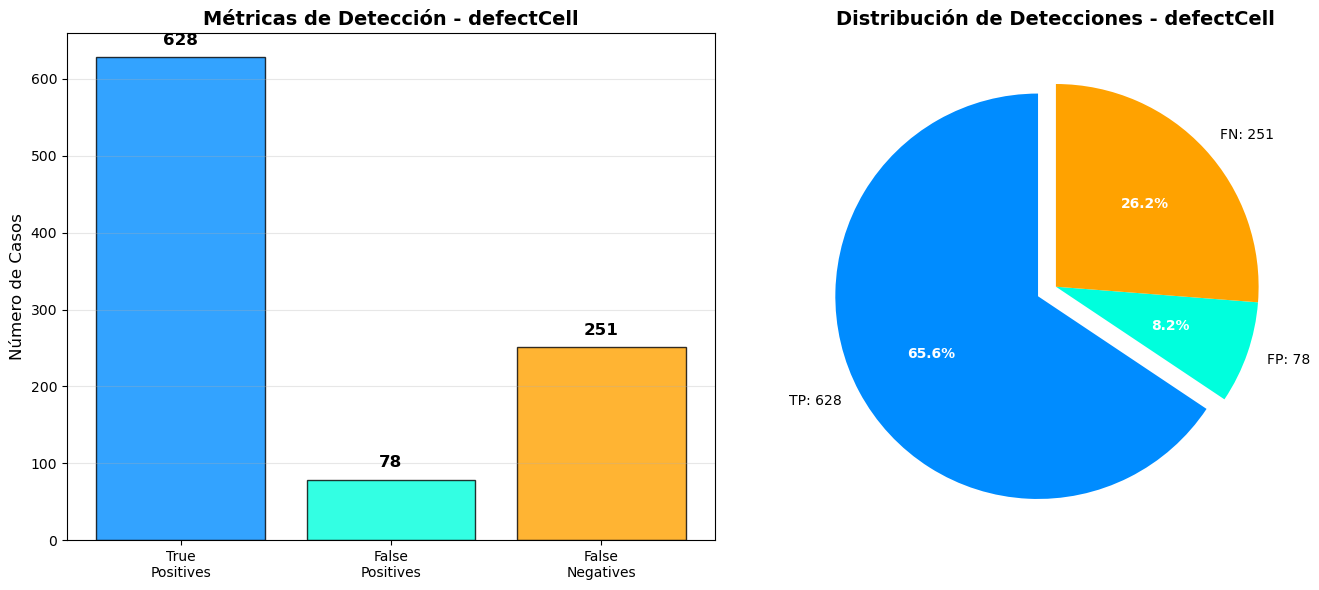

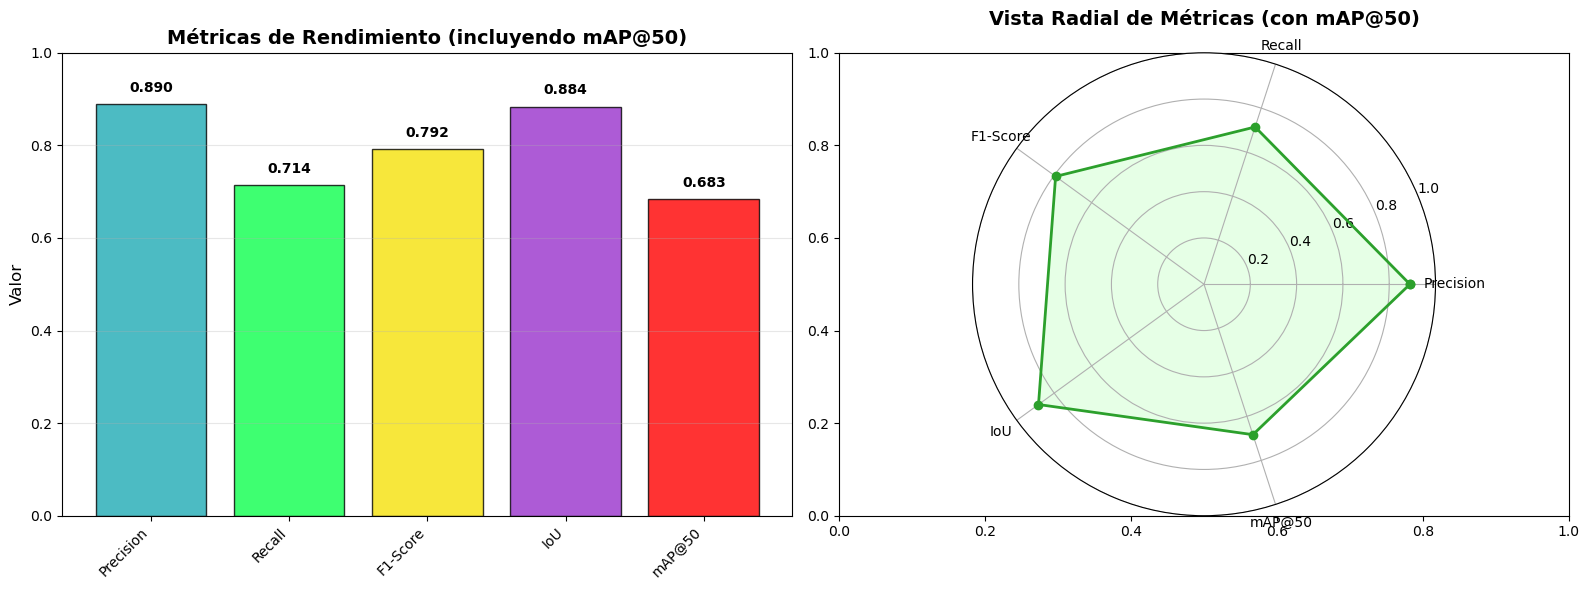

Model improved. New best F1: 0.7924


Epoch 2/8: 100%|██████████| 280/280 [04:07<00:00,  1.13batch/s, loss=0.0832]


Training Loss: 0.2062


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  3.02it/s]



MÉTRICAS DE DETECCIÓN - DEFECTCELL
True Positives (TP):     595
False Positives (FP):    63
False Negatives (FN):    284
------------------------------------------------------------
Precision:               0.9043
Recall:                  0.6769
F1-Score:                0.7742
IoU Promedio:            0.8864
mAP@50:                  0.6632
------------------------------------------------------------
Total objetos GT:        879
Total predicciones:      658
Umbral confianza:        0.85
Umbral IoU:              0.6


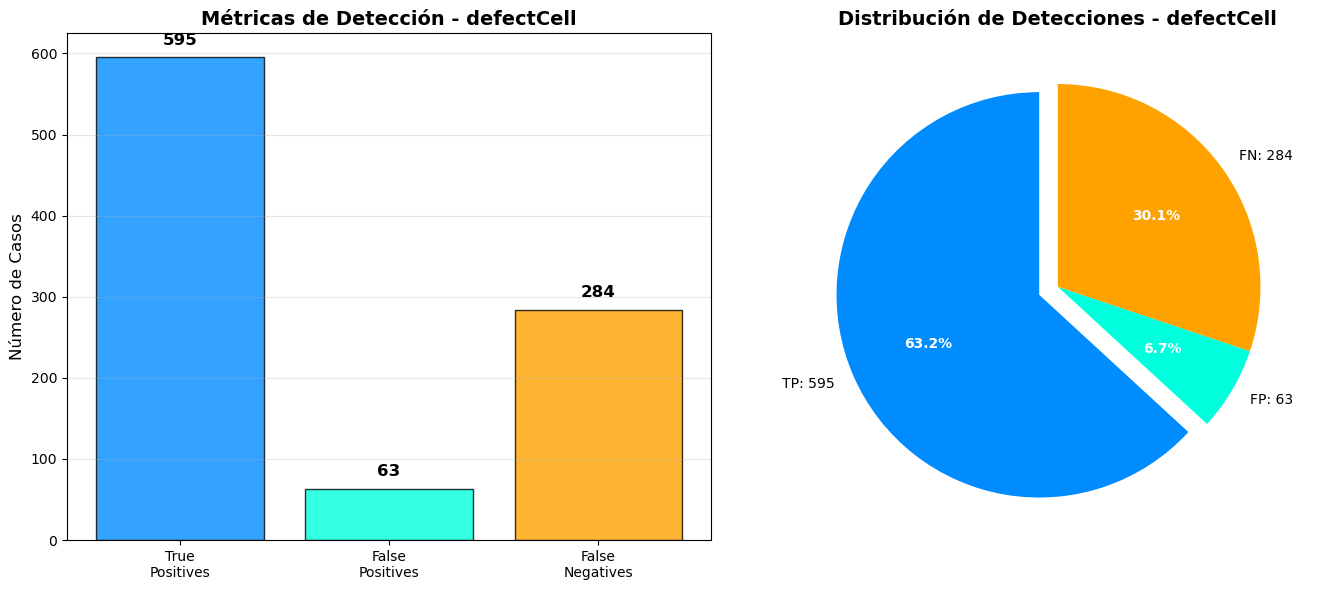

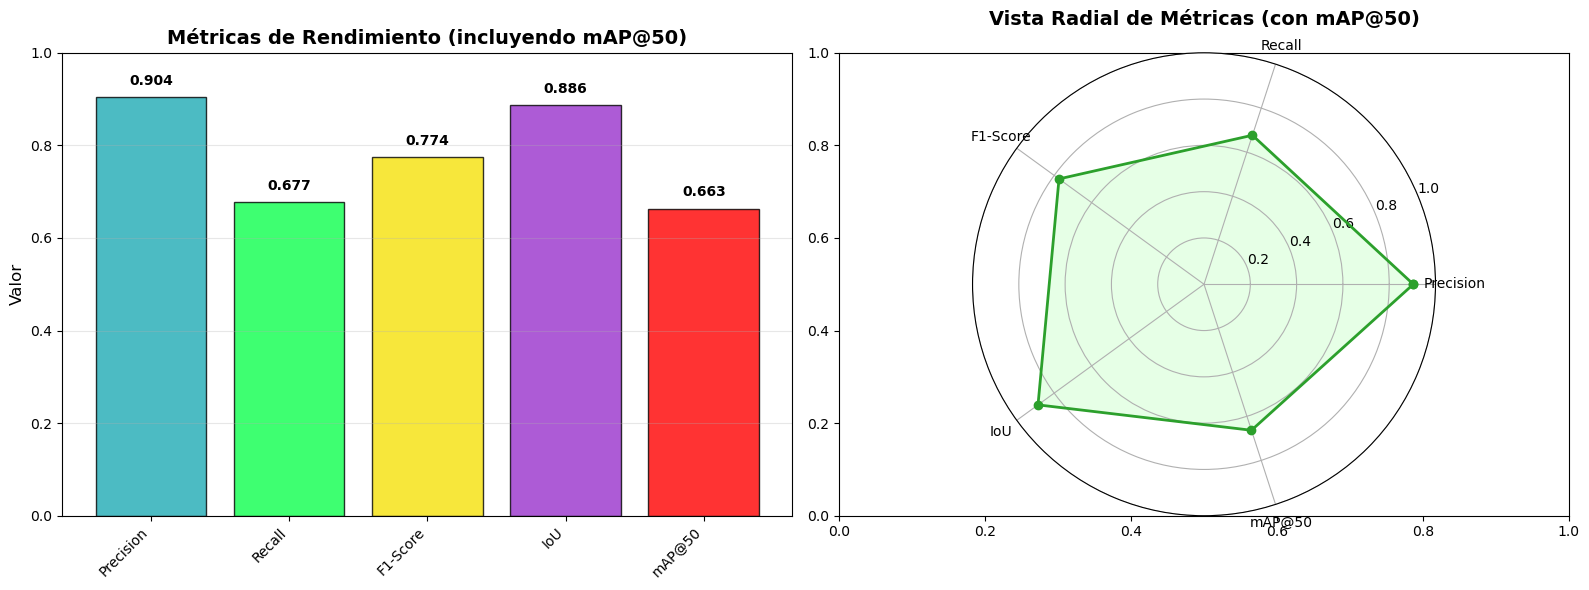

No improvement in F1. Patience: 1/3


Epoch 3/8: 100%|██████████| 280/280 [04:07<00:00,  1.13batch/s, loss=0.107] 


Training Loss: 0.1798


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  3.01it/s]



MÉTRICAS DE DETECCIÓN - DEFECTCELL
True Positives (TP):     614
False Positives (FP):    74
False Negatives (FN):    265
------------------------------------------------------------
Precision:               0.8924
Recall:                  0.6985
F1-Score:                0.7837
IoU Promedio:            0.8913
mAP@50:                  0.6752
------------------------------------------------------------
Total objetos GT:        879
Total predicciones:      688
Umbral confianza:        0.85
Umbral IoU:              0.6


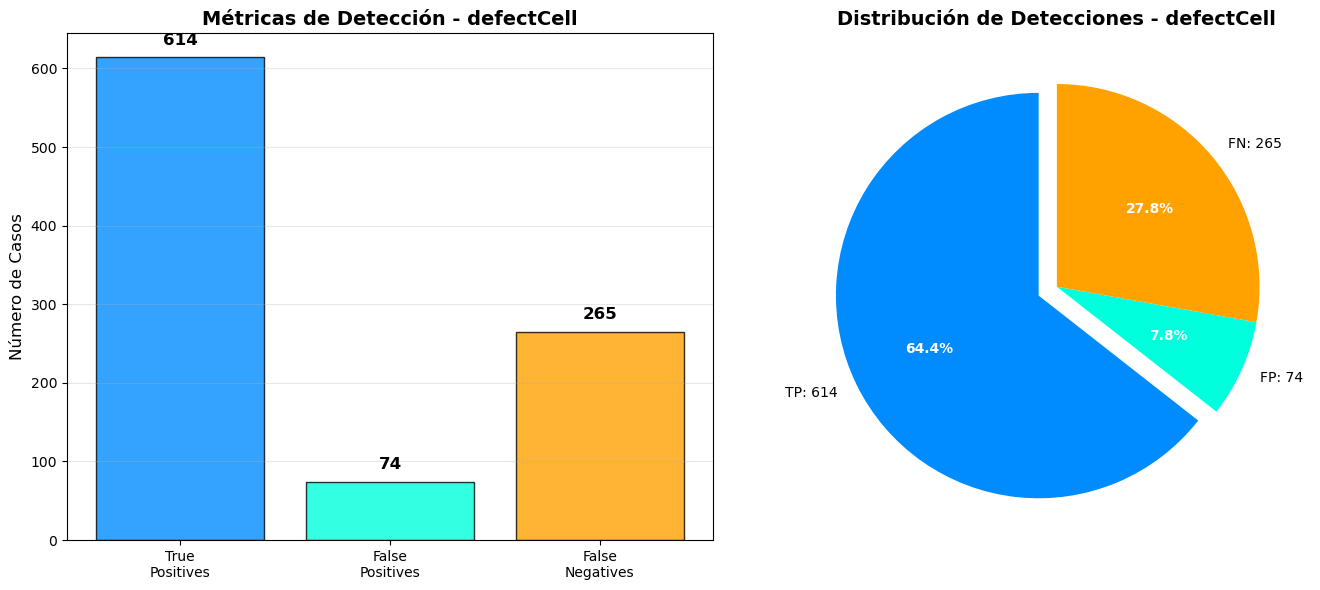

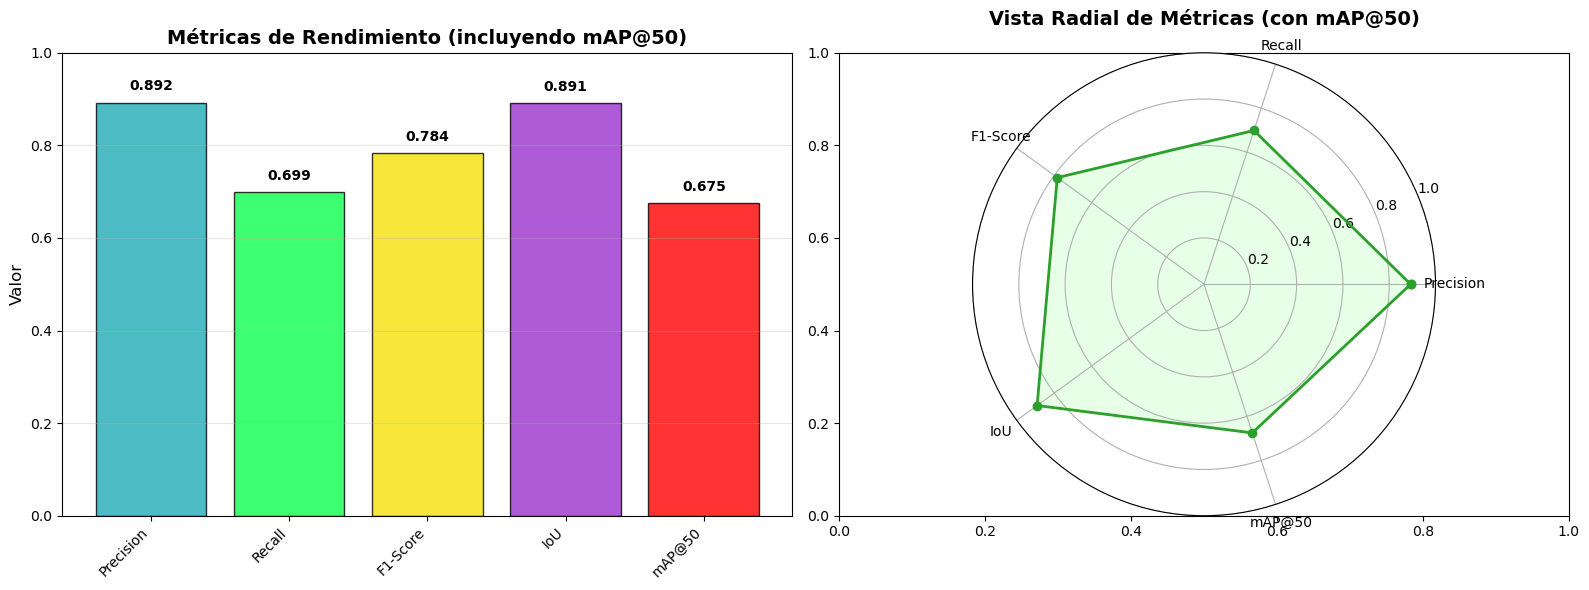

No improvement in F1. Patience: 2/3


Epoch 4/8: 100%|██████████| 280/280 [04:08<00:00,  1.13batch/s, loss=0.229] 


Training Loss: 0.1423


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  3.01it/s]



MÉTRICAS DE DETECCIÓN - DEFECTCELL
True Positives (TP):     689
False Positives (FP):    134
False Negatives (FN):    190
------------------------------------------------------------
Precision:               0.8372
Recall:                  0.7838
F1-Score:                0.8096
IoU Promedio:            0.8913
mAP@50:                  0.7613
------------------------------------------------------------
Total objetos GT:        879
Total predicciones:      823
Umbral confianza:        0.85
Umbral IoU:              0.6


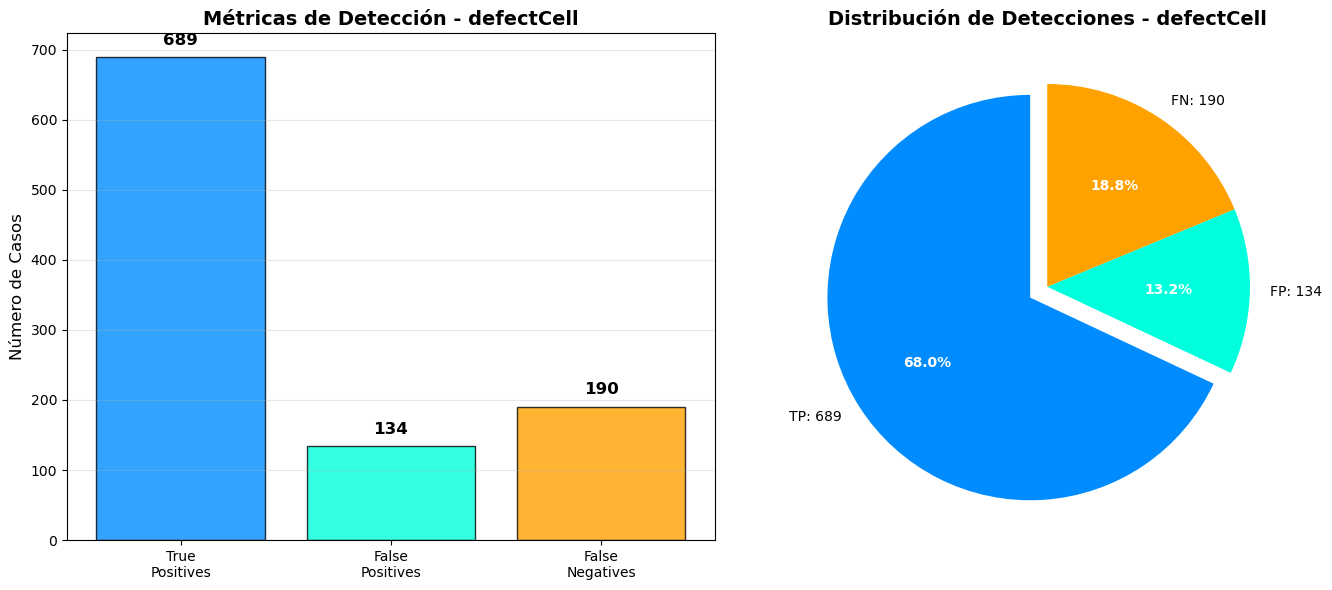

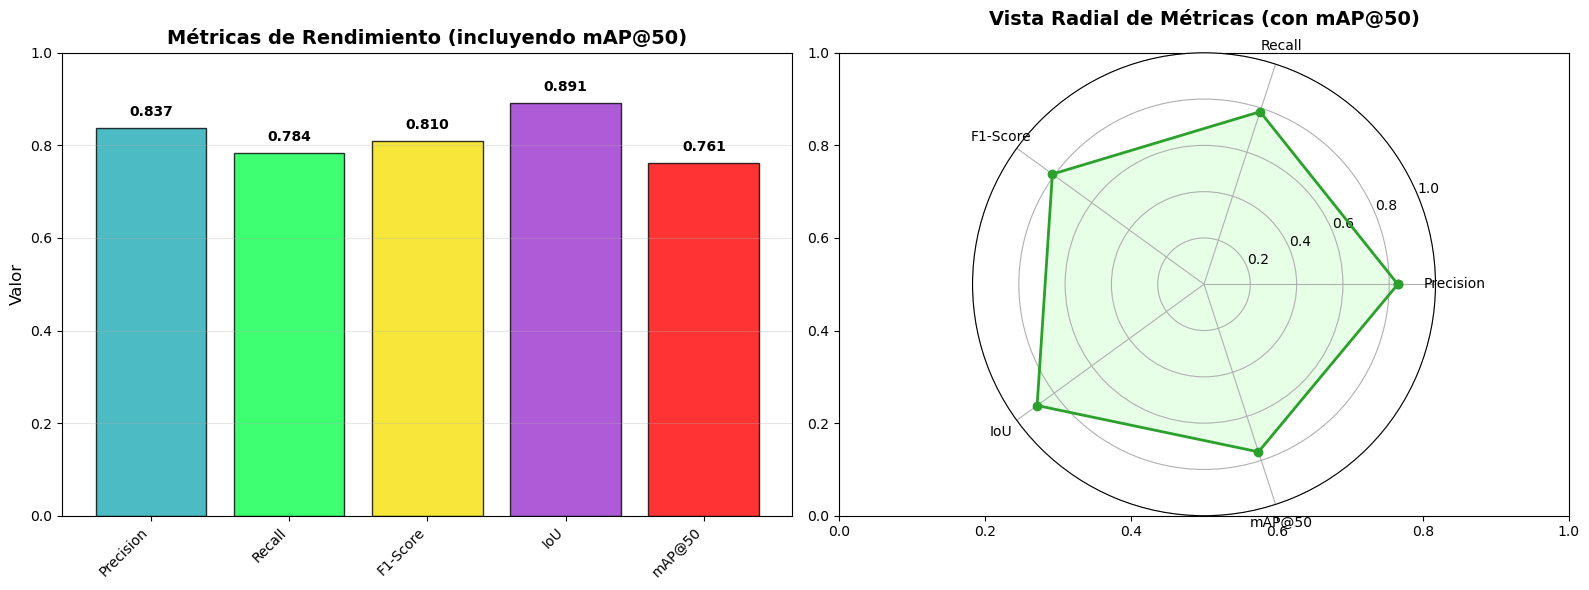

Model improved. New best F1: 0.8096


Epoch 5/8: 100%|██████████| 280/280 [04:07<00:00,  1.13batch/s, loss=0.18]   


Training Loss: 0.1359


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  3.02it/s]



MÉTRICAS DE DETECCIÓN - DEFECTCELL
True Positives (TP):     693
False Positives (FP):    138
False Negatives (FN):    186
------------------------------------------------------------
Precision:               0.8339
Recall:                  0.7884
F1-Score:                0.8105
IoU Promedio:            0.8910
mAP@50:                  0.7828
------------------------------------------------------------
Total objetos GT:        879
Total predicciones:      831
Umbral confianza:        0.85
Umbral IoU:              0.6


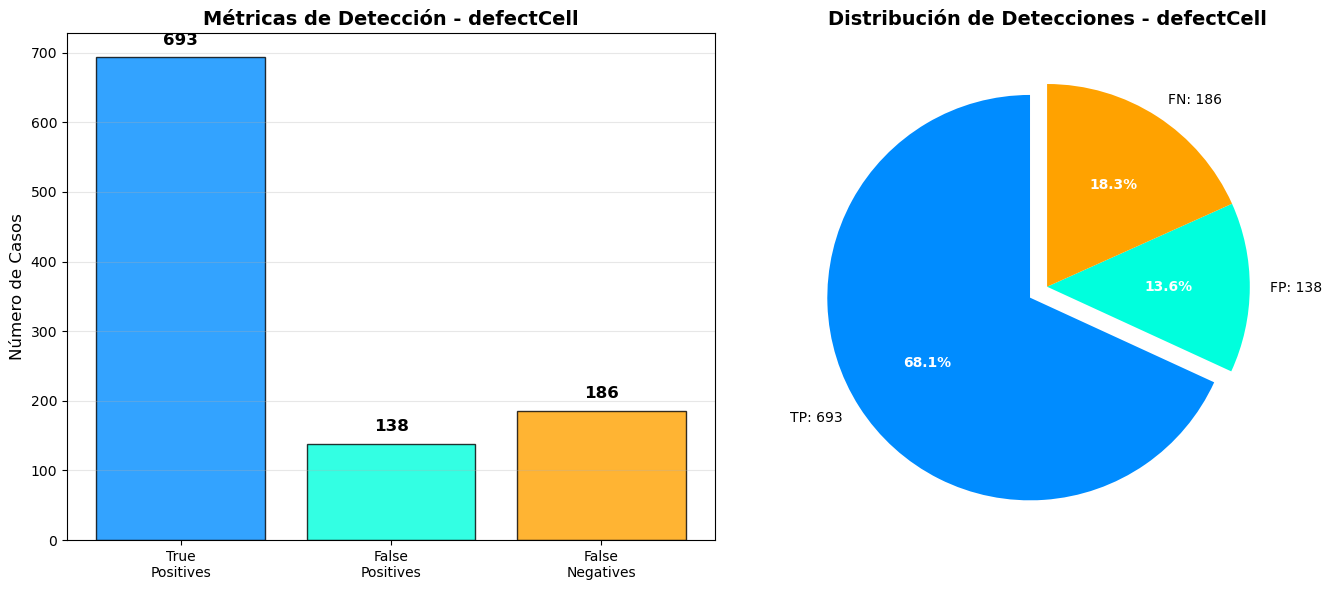

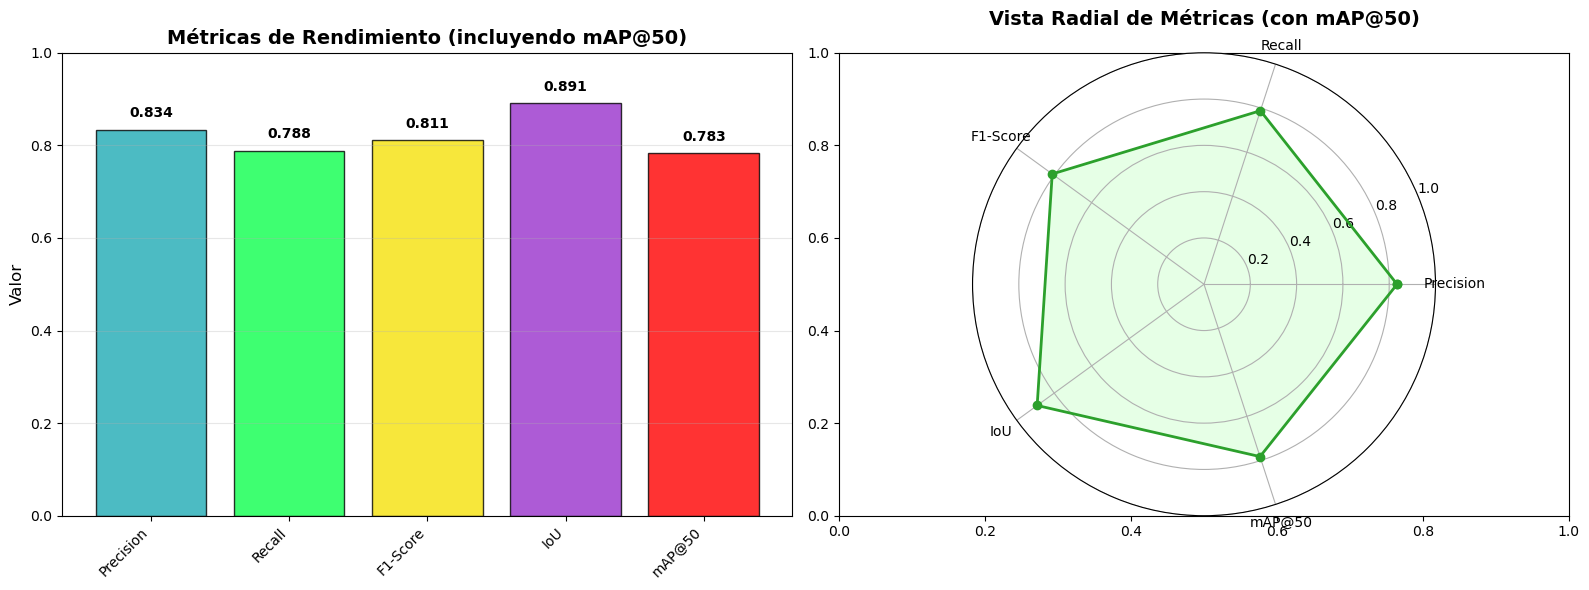

No improvement in F1. Patience: 1/3


Epoch 6/8: 100%|██████████| 280/280 [04:07<00:00,  1.13batch/s, loss=0.0415]


Training Loss: 0.1310


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  2.99it/s]



MÉTRICAS DE DETECCIÓN - DEFECTCELL
True Positives (TP):     666
False Positives (FP):    114
False Negatives (FN):    213
------------------------------------------------------------
Precision:               0.8538
Recall:                  0.7577
F1-Score:                0.8029
IoU Promedio:            0.8903
mAP@50:                  0.7445
------------------------------------------------------------
Total objetos GT:        879
Total predicciones:      780
Umbral confianza:        0.85
Umbral IoU:              0.6


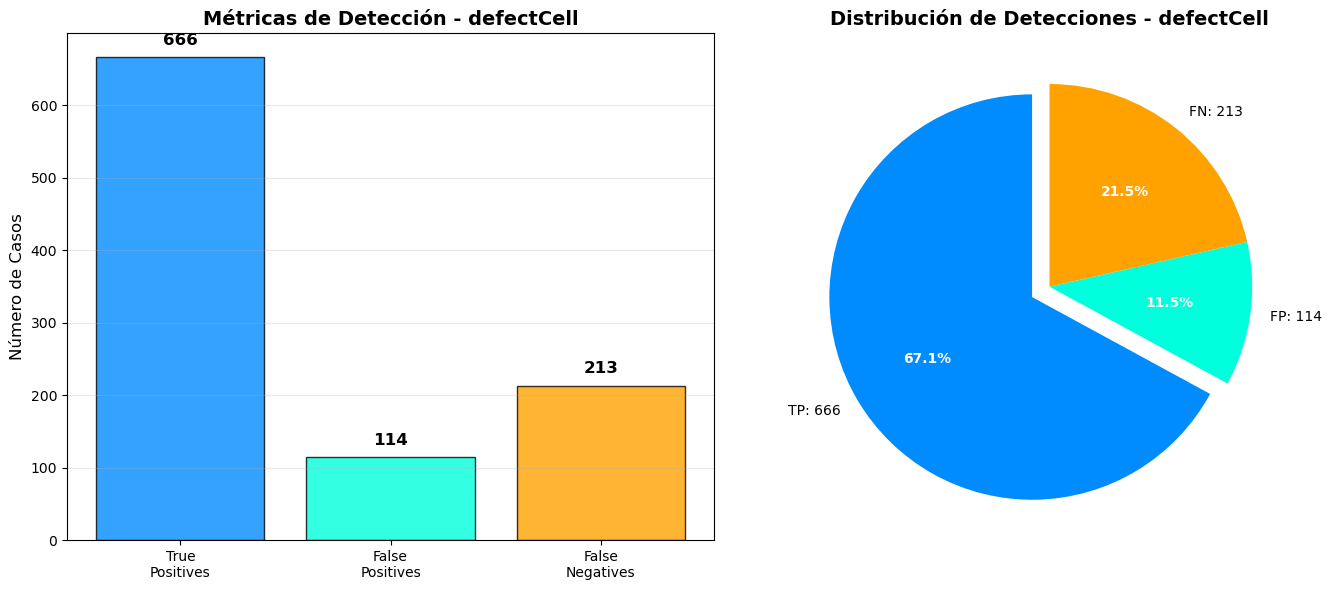

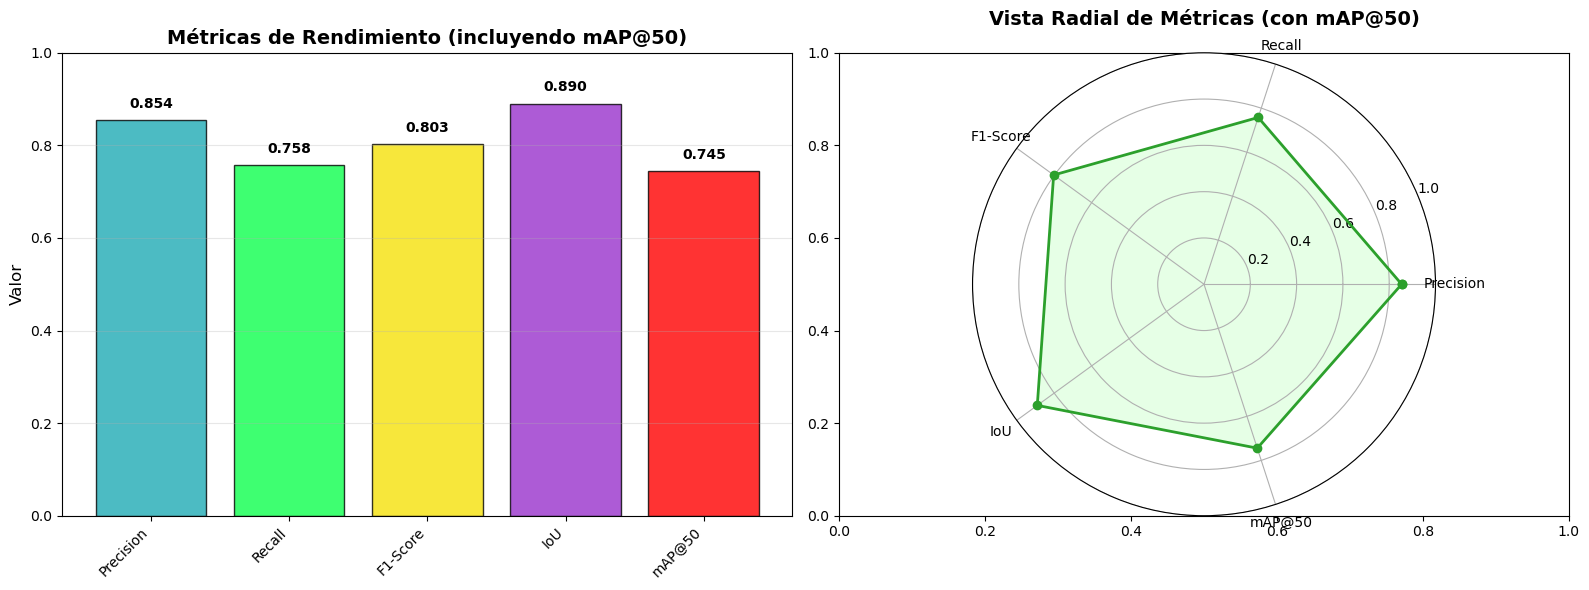

No improvement in F1. Patience: 2/3


Epoch 7/8: 100%|██████████| 280/280 [04:06<00:00,  1.13batch/s, loss=0.0172]


Training Loss: 0.1268


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  3.01it/s]



MÉTRICAS DE DETECCIÓN - DEFECTCELL
True Positives (TP):     670
False Positives (FP):    124
False Negatives (FN):    209
------------------------------------------------------------
Precision:               0.8438
Recall:                  0.7622
F1-Score:                0.8010
IoU Promedio:            0.8914
mAP@50:                  0.7384
------------------------------------------------------------
Total objetos GT:        879
Total predicciones:      794
Umbral confianza:        0.85
Umbral IoU:              0.6


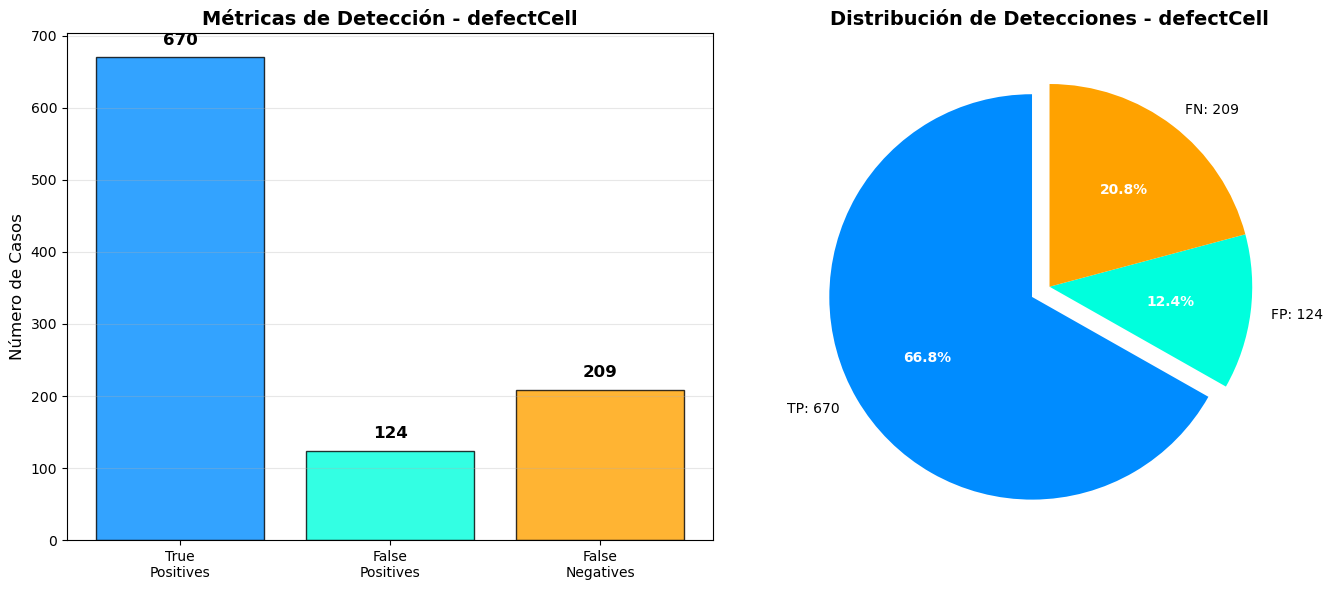

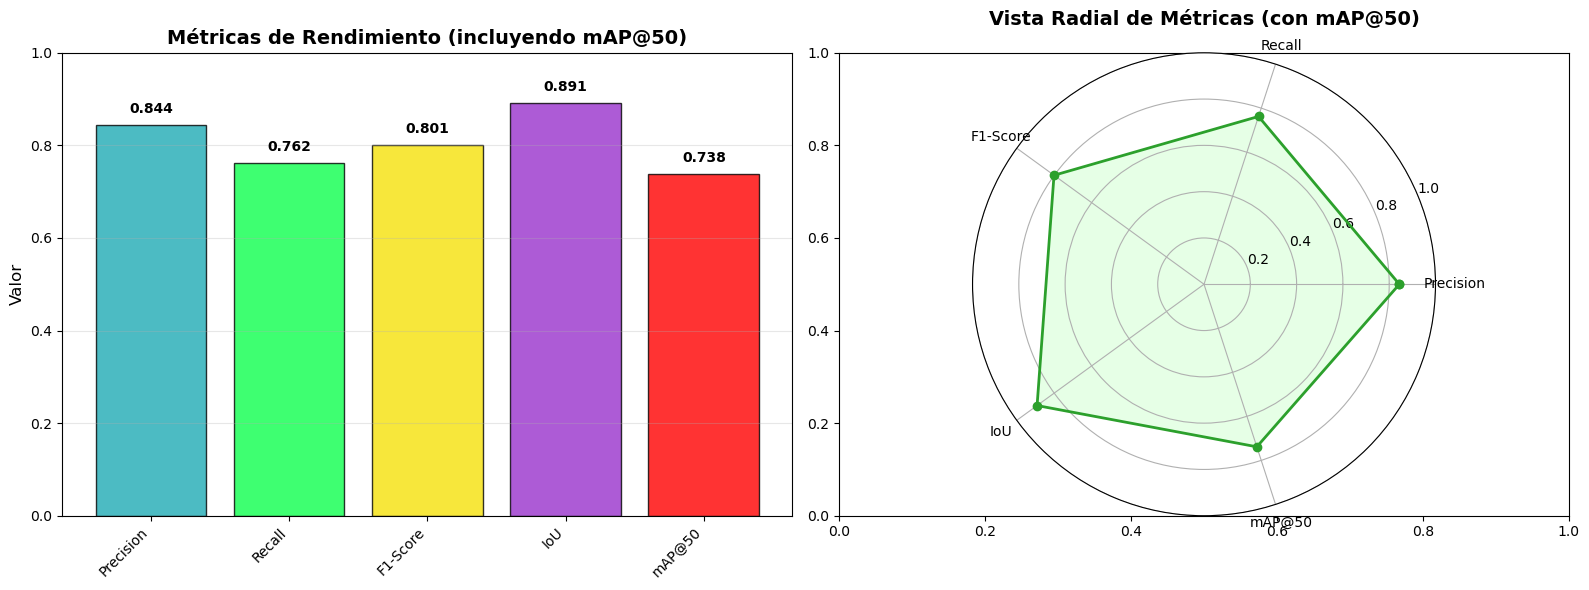

Early stopping triggered. Best F1: 0.8096


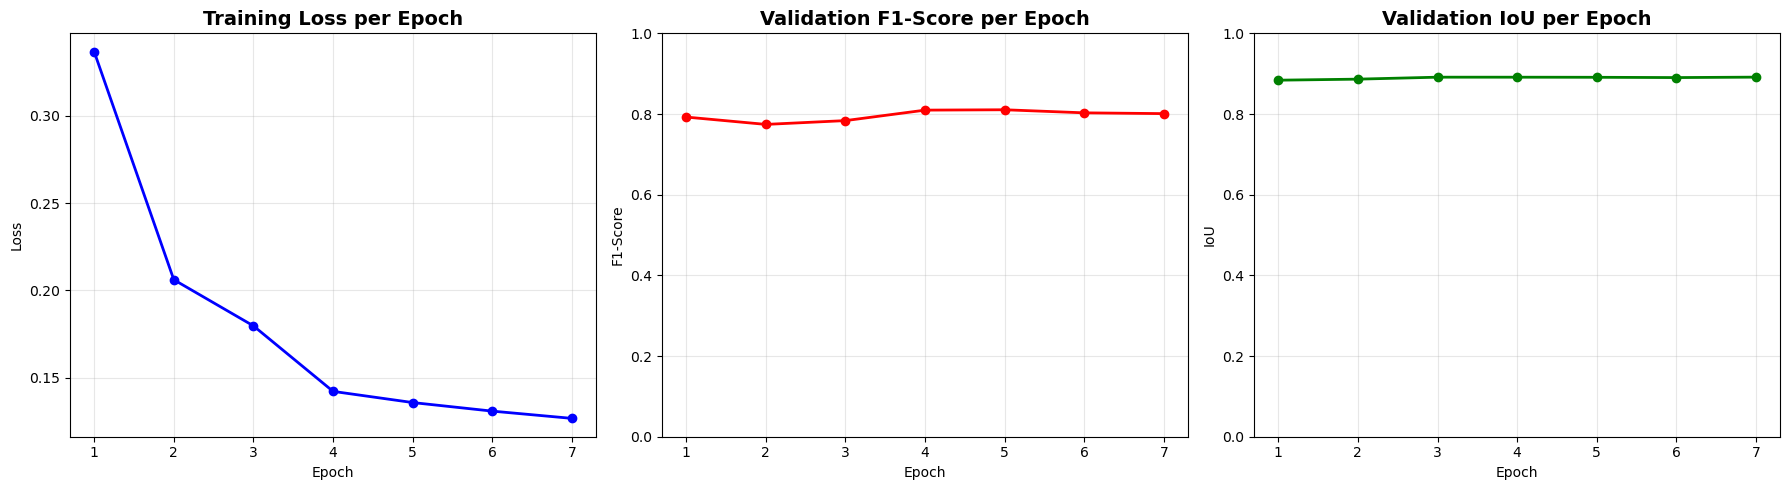

In [7]:
# Entrenar modelo
trainer.train_model(
    model=model,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    num_epochs=8,
    train_loader=train_loader,
    val_loader=val_loader,
    confidence_threshold=0.85,
    iou_threshold=0.6
)

Guardando imágenes en: ../03.Datasets/Evaluacion_Empresa/DEFAULT/RCNN
Modelo cargado correctamente


Evaluando test: 100%|██████████| 87/87 [00:34<00:00,  2.54it/s]



MÉTRICAS DE DETECCIÓN - DEFECTCELL
True Positives (TP):     1076
False Positives (FP):    228
False Negatives (FN):    197
------------------------------------------------------------
Precision:               0.8252
Recall:                  0.8452
F1-Score:                0.8351
IoU Promedio:            0.8880
mAP@50:                  0.8248
------------------------------------------------------------
Total objetos GT:        1273
Total predicciones:      1304
Umbral confianza:        0.85
Umbral IoU:              0.6


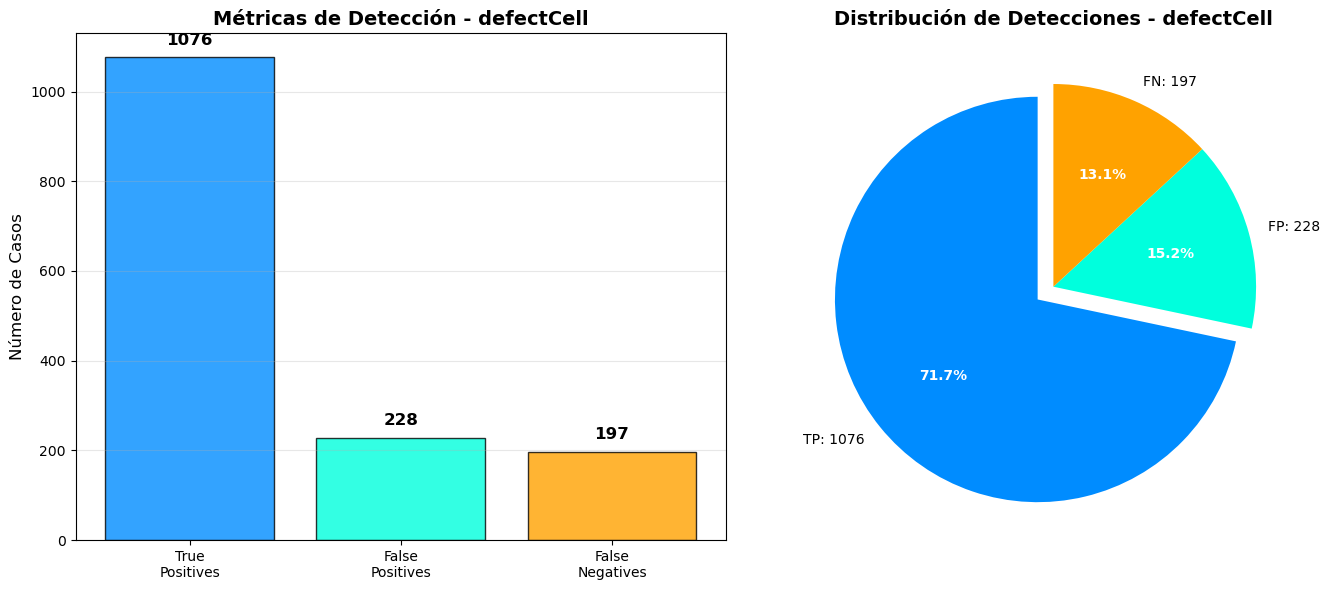

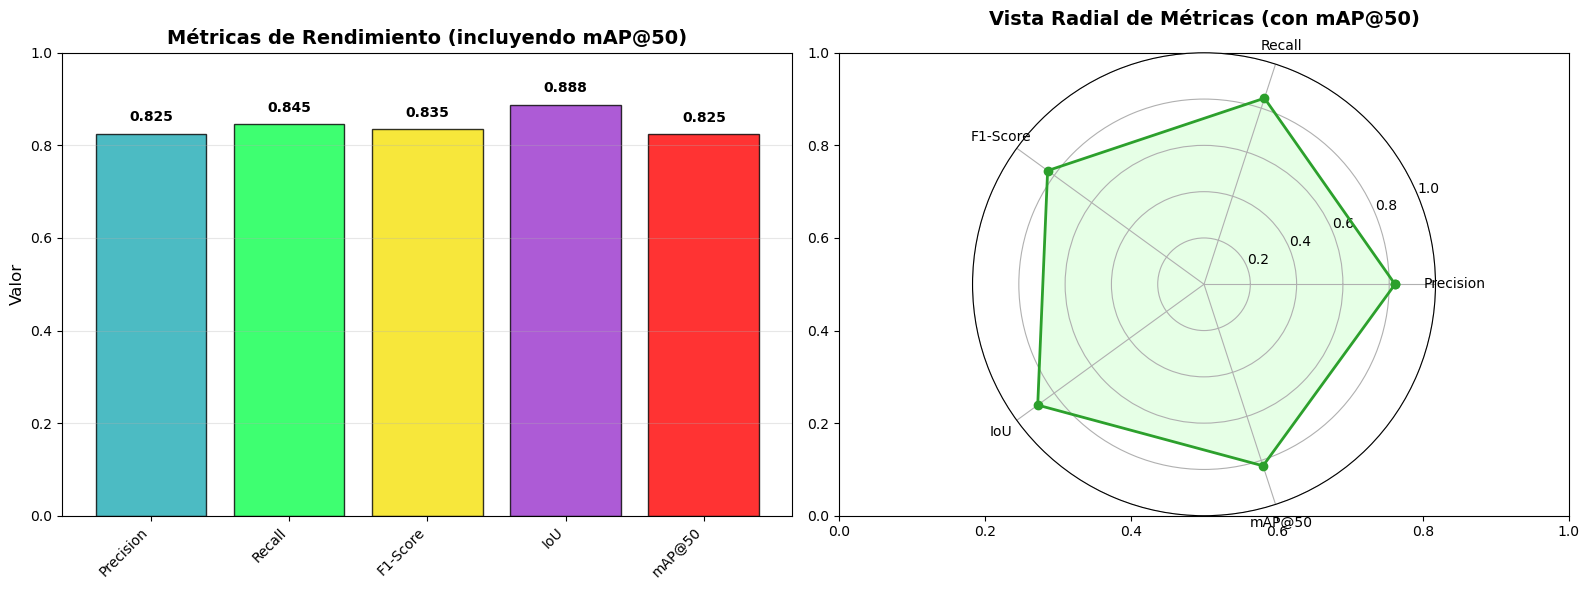


Se guardaron las imágenes en ../03.Datasets/Evaluacion_Empresa/DEFAULT/RCNN
Leyenda: Cajas VERDES = Ground Truth, Cajas ROJAS = Predicciones


In [8]:
# Evaluar en test con métricas 
trainer.evaluate_test(
    test_loader=test_loader,
    test_dataset=test_ds,
    weights_model="./Fast_RCNN_models/best_model.pth",
    confidence_threshold=0.85,
    iou_threshold=0.6,
    save_images=True,
    output_path="../03.Datasets/Evaluacion_Empresa/DEFAULT/RCNN"
)


Fold 1/5


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  2.95it/s]



MÉTRICAS DE DETECCIÓN - DEFECTCELL
True Positives (TP):     849
False Positives (FP):    164
False Negatives (FN):    224
------------------------------------------------------------
Precision:               0.8381
Recall:                  0.7912
F1-Score:                0.8140
IoU Promedio:            0.8522
mAP@50:                  0.7176
------------------------------------------------------------
Total objetos GT:        1073
Total predicciones:      1013
Umbral confianza:        0.85
Umbral IoU:              0.6


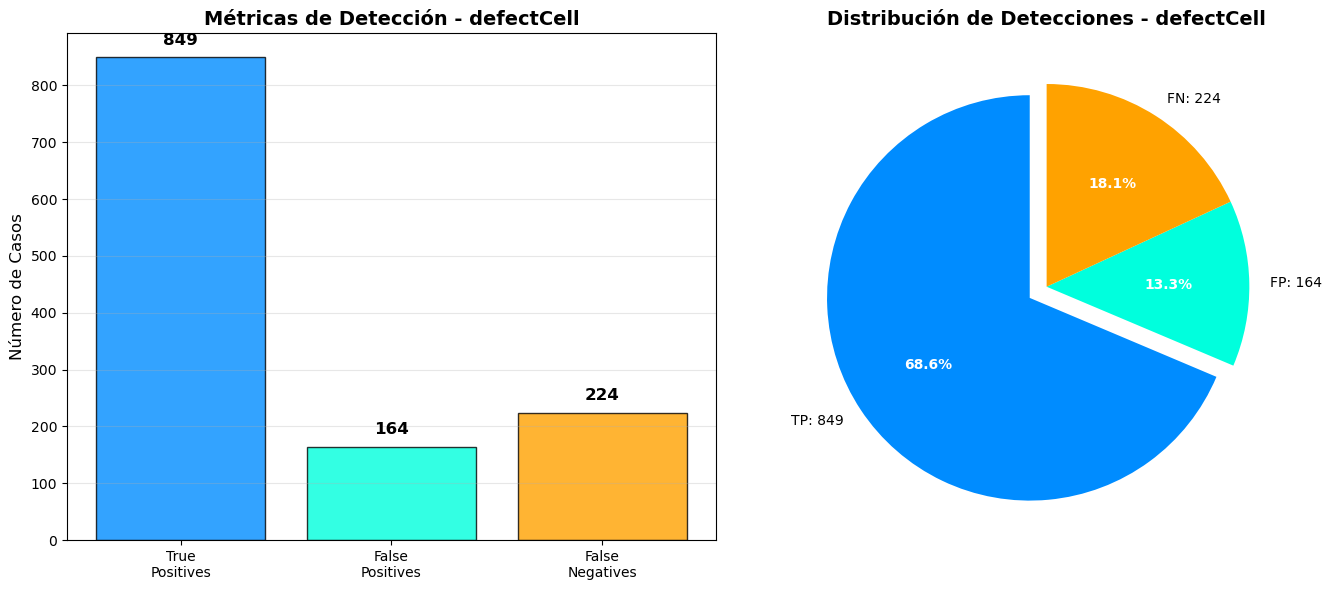

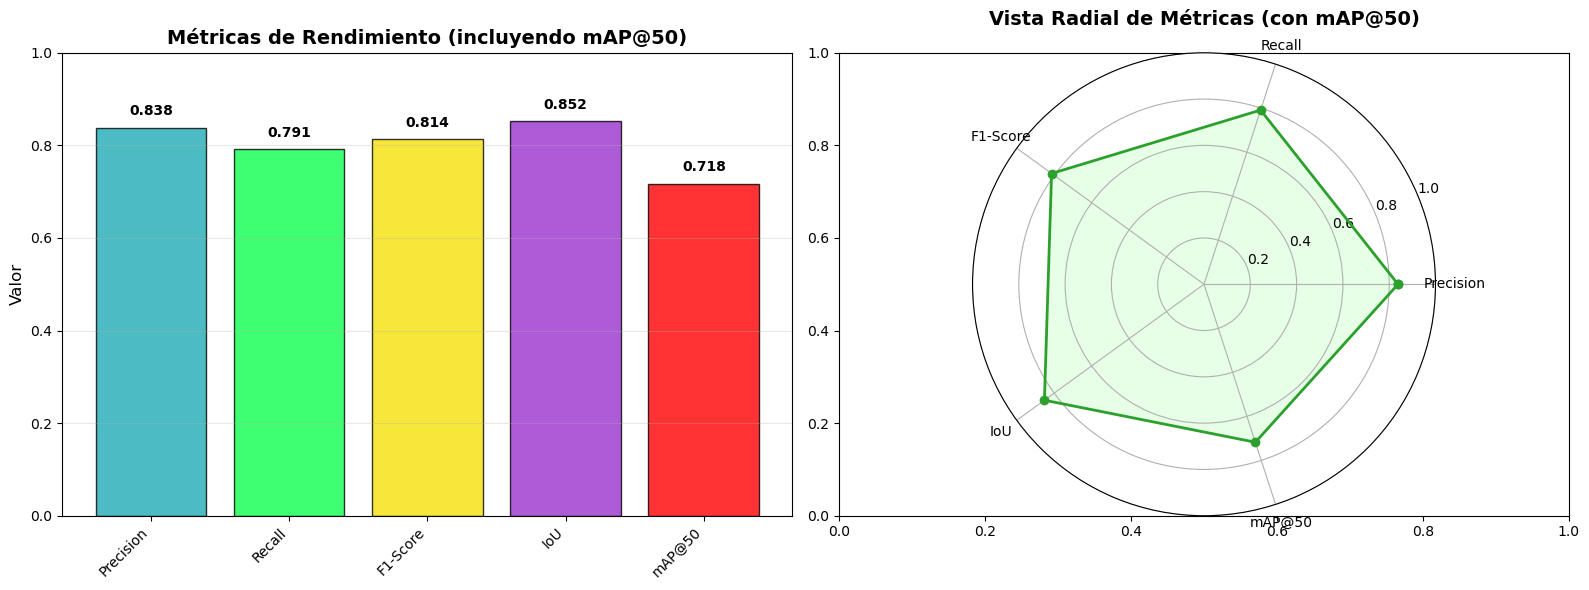

Modelo mejorado. Nuevo mejor F1: 0.8140

Fold 2/5


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  3.00it/s]



MÉTRICAS DE DETECCIÓN - DEFECTCELL
True Positives (TP):     884
False Positives (FP):    109
False Negatives (FN):    272
------------------------------------------------------------
Precision:               0.8902
Recall:                  0.7647
F1-Score:                0.8227
IoU Promedio:            0.8826
mAP@50:                  0.7117
------------------------------------------------------------
Total objetos GT:        1156
Total predicciones:      993
Umbral confianza:        0.85
Umbral IoU:              0.6


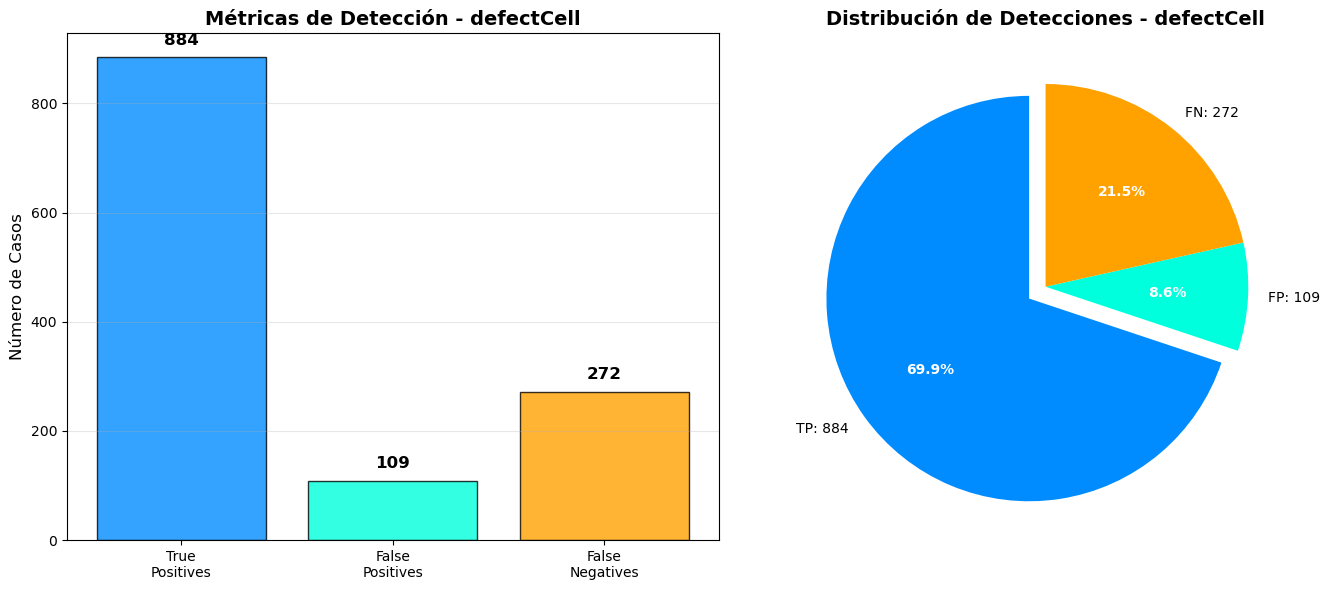

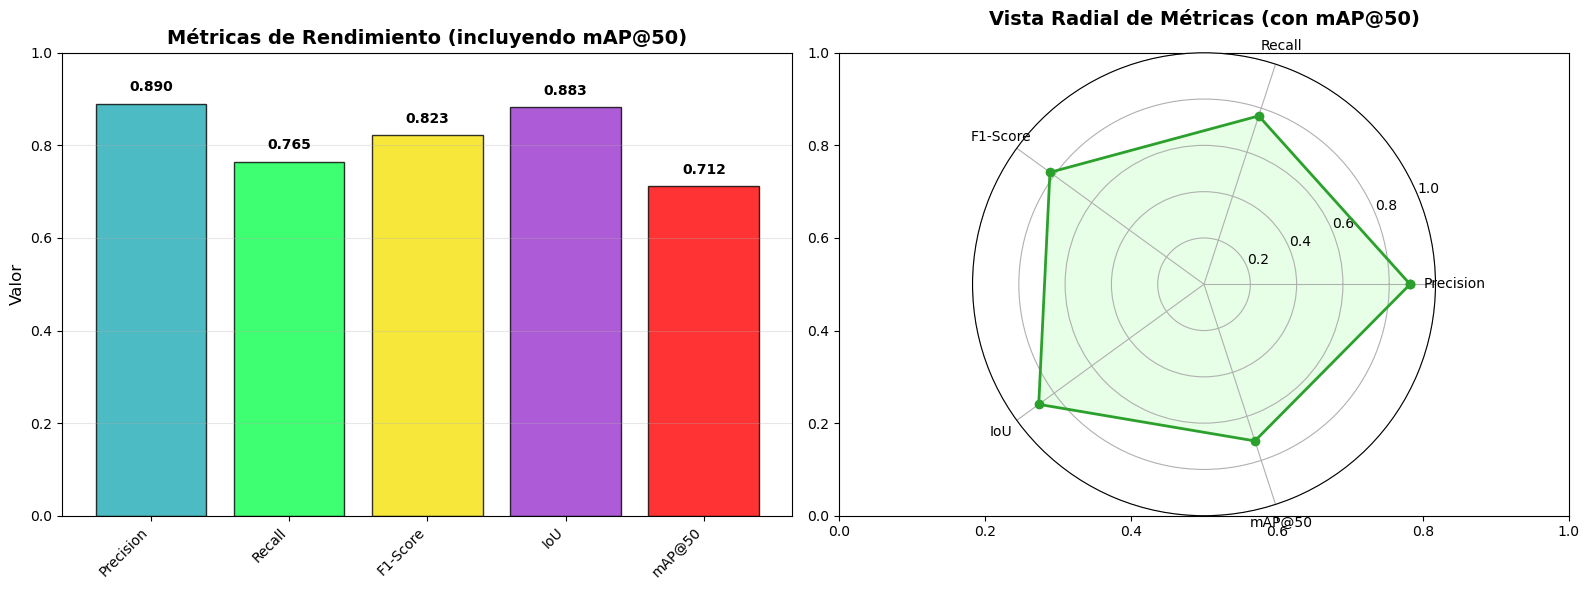

Modelo mejorado. Nuevo mejor F1: 0.8227

Fold 3/5


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  3.02it/s]



MÉTRICAS DE DETECCIÓN - DEFECTCELL
True Positives (TP):     526
False Positives (FP):    68
False Negatives (FN):    303
------------------------------------------------------------
Precision:               0.8855
Recall:                  0.6345
F1-Score:                0.7393
IoU Promedio:            0.8627
mAP@50:                  0.6005
------------------------------------------------------------
Total objetos GT:        829
Total predicciones:      594
Umbral confianza:        0.85
Umbral IoU:              0.6


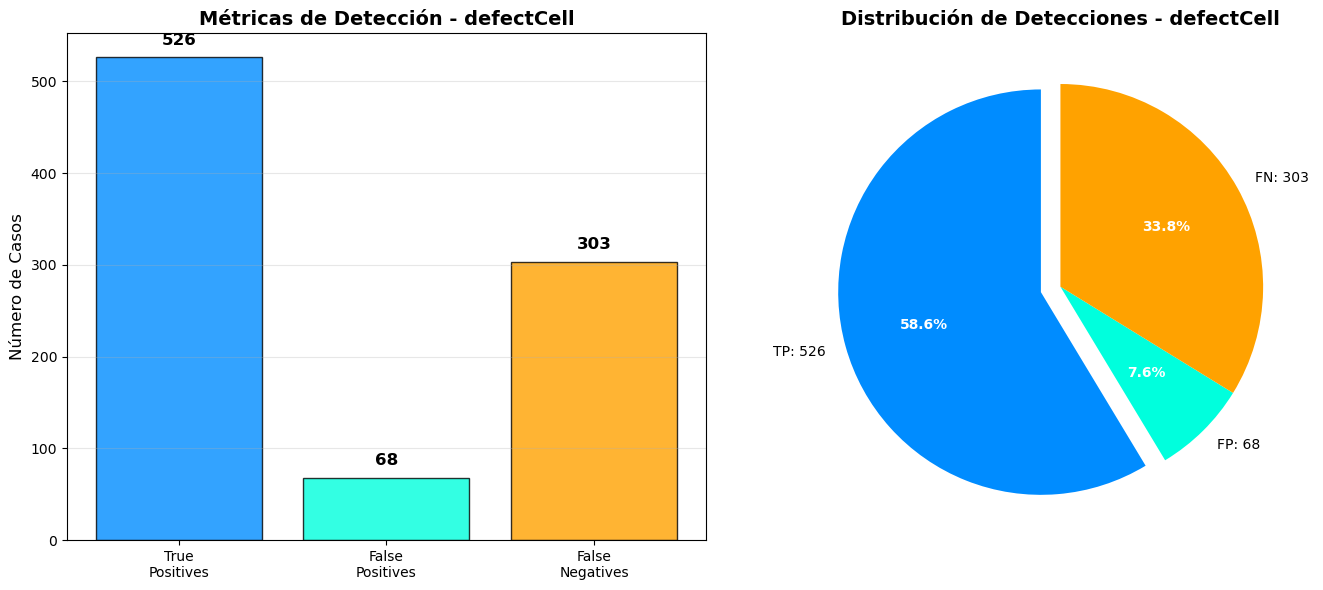

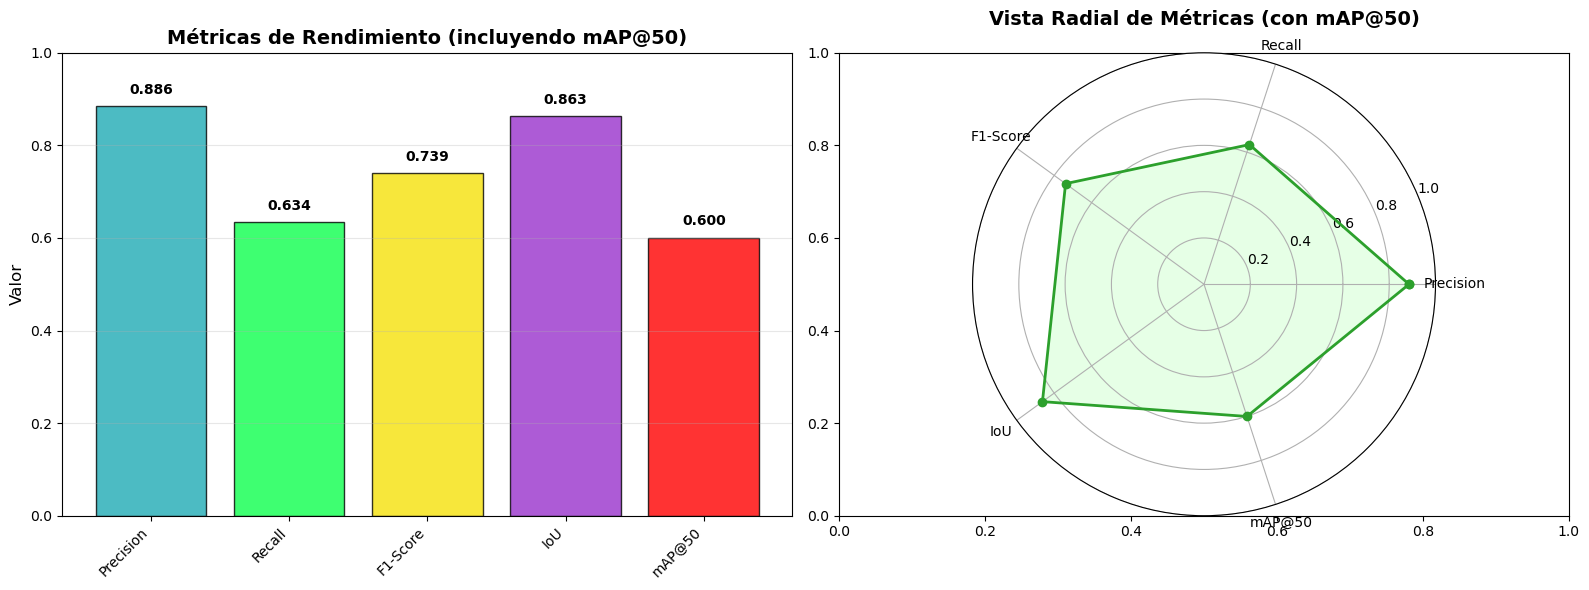

Modelo mejorado. Nuevo mejor F1: 0.7393

Fold 4/5


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  2.99it/s]



MÉTRICAS DE DETECCIÓN - DEFECTCELL
True Positives (TP):     813
False Positives (FP):    244
False Negatives (FN):    97
------------------------------------------------------------
Precision:               0.7692
Recall:                  0.8934
F1-Score:                0.8266
IoU Promedio:            0.8815
mAP@50:                  0.8235
------------------------------------------------------------
Total objetos GT:        910
Total predicciones:      1057
Umbral confianza:        0.85
Umbral IoU:              0.6


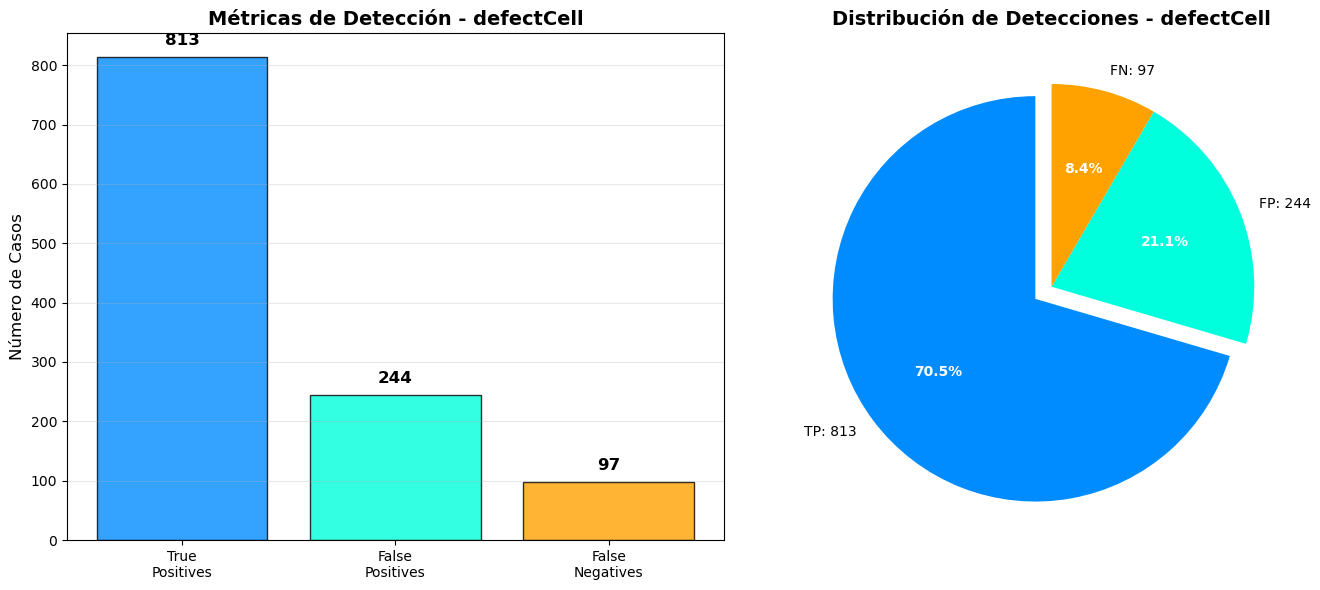

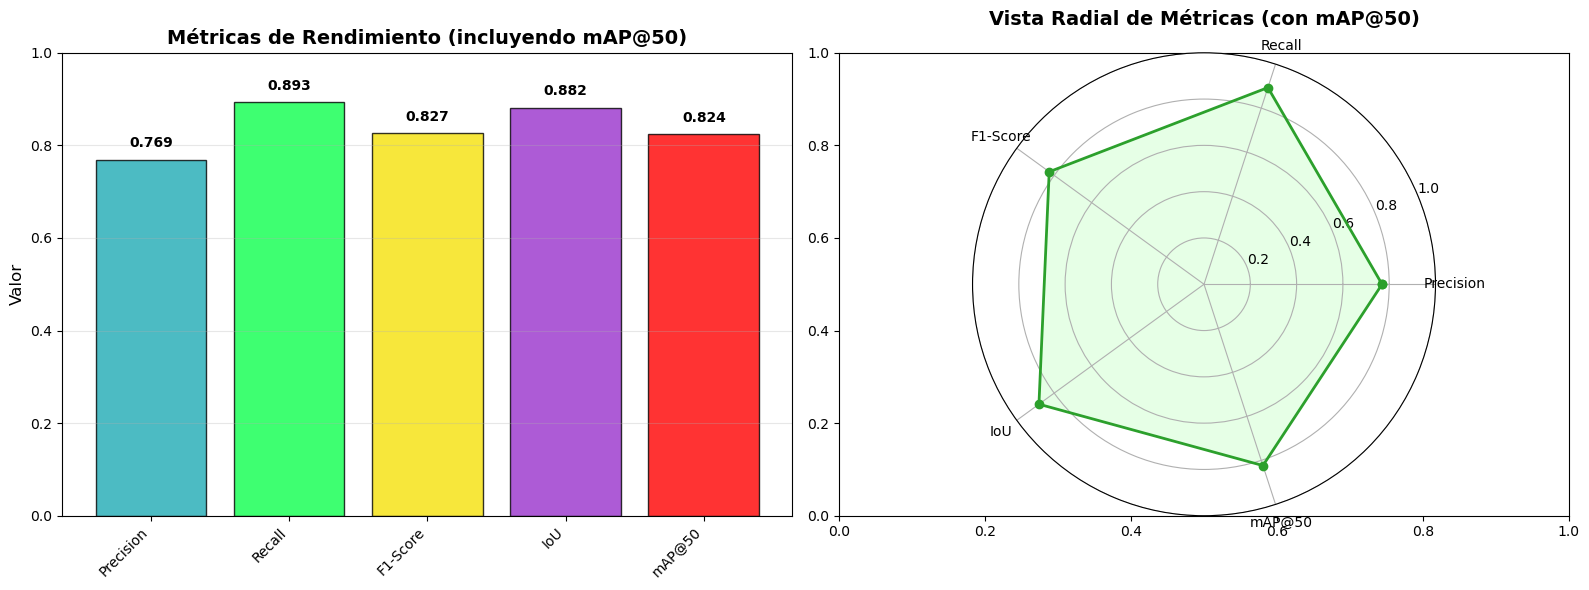

Modelo mejorado. Nuevo mejor F1: 0.8266

Fold 5/5


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  2.97it/s]



MÉTRICAS DE DETECCIÓN - DEFECTCELL
True Positives (TP):     733
False Positives (FP):    202
False Negatives (FN):    111
------------------------------------------------------------
Precision:               0.7840
Recall:                  0.8685
F1-Score:                0.8241
IoU Promedio:            0.8639
mAP@50:                  0.8393
------------------------------------------------------------
Total objetos GT:        844
Total predicciones:      935
Umbral confianza:        0.85
Umbral IoU:              0.6


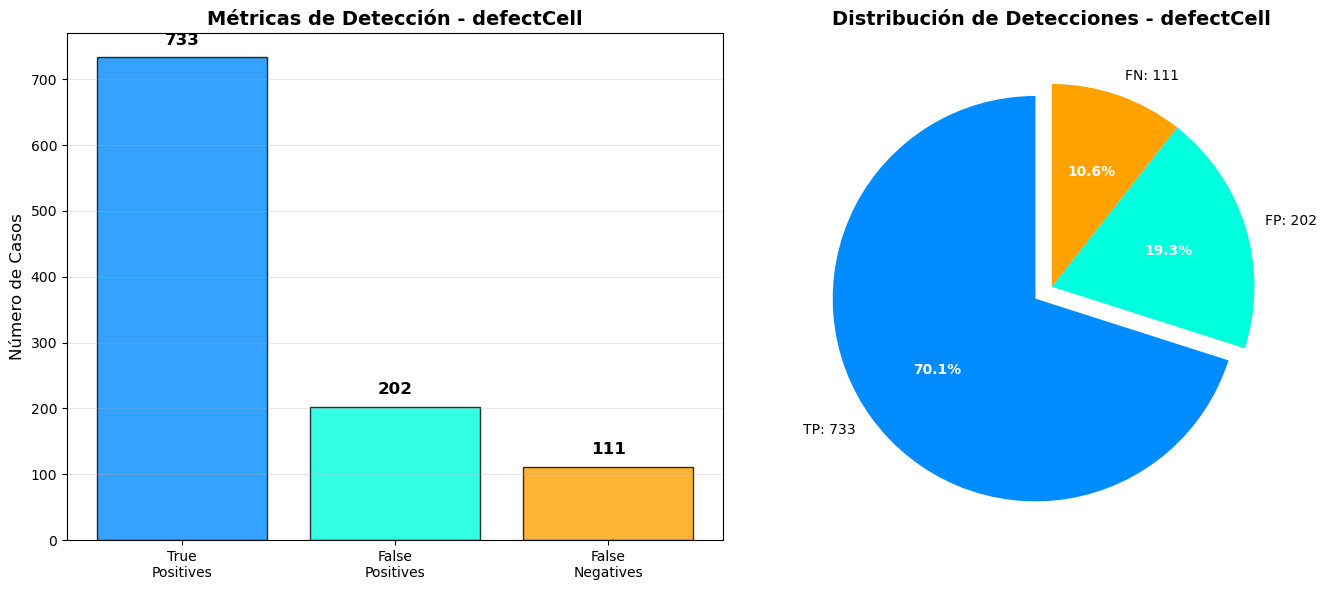

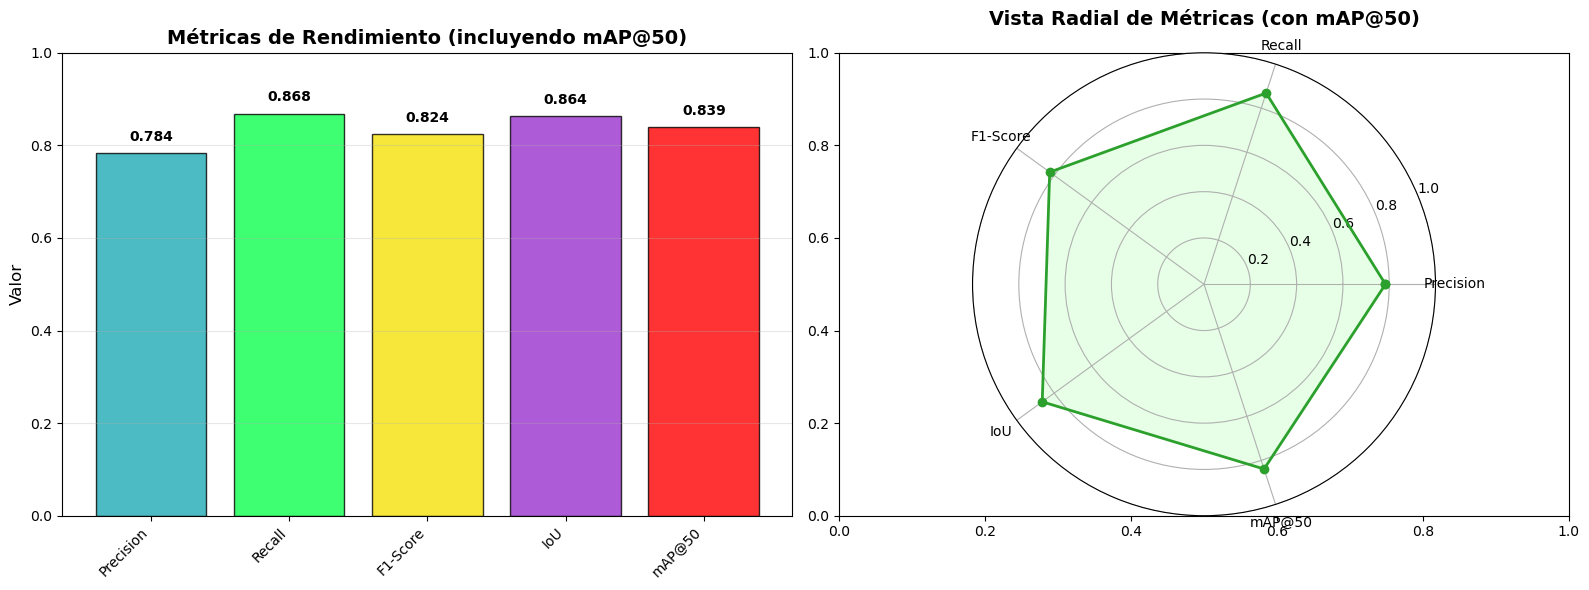

Modelo mejorado. Nuevo mejor F1: 0.8241

==== Resultados de K-Fold Cross Validation ====
F1 Score medio: 0.8053 ± 0.0333
IoU medio: 0.8686 ± 0.0117
Fold 1: F1=0.8140, IoU=0.8522
Fold 2: F1=0.8227, IoU=0.8826
Fold 3: F1=0.7393, IoU=0.8627
Fold 4: F1=0.8266, IoU=0.8815
Fold 5: F1=0.8241, IoU=0.8639


In [12]:
# Ejecutar K-fold
trainer.run_kfold_cv(
    train_dataset=train_ds,
    val_dataset=val_ds,
    k=5,
    num_epochs=1,
    collate_fn=collate_fn,
    optimizer_params={'optimizer_type': 'sgd', 'learning_rate': 0.005},
    train_params={'confidence_threshold': 0.85, 'iou_threshold': 0.6}
)

Guardando imágenes en: ../03.Datasets/Evaluacion_Empresa/DEFAULT/kfold_RCNN
Modelo cargado correctamente


Evaluando test: 100%|██████████| 87/87 [00:35<00:00,  2.45it/s]



MÉTRICAS DE DETECCIÓN - DEFECTCELL
True Positives (TP):     1158
False Positives (FP):    376
False Negatives (FN):    115
------------------------------------------------------------
Precision:               0.7549
Recall:                  0.9097
F1-Score:                0.8251
IoU Promedio:            0.8794
mAP@50:                  0.8592
------------------------------------------------------------
Total objetos GT:        1273
Total predicciones:      1534
Umbral confianza:        0.85
Umbral IoU:              0.6


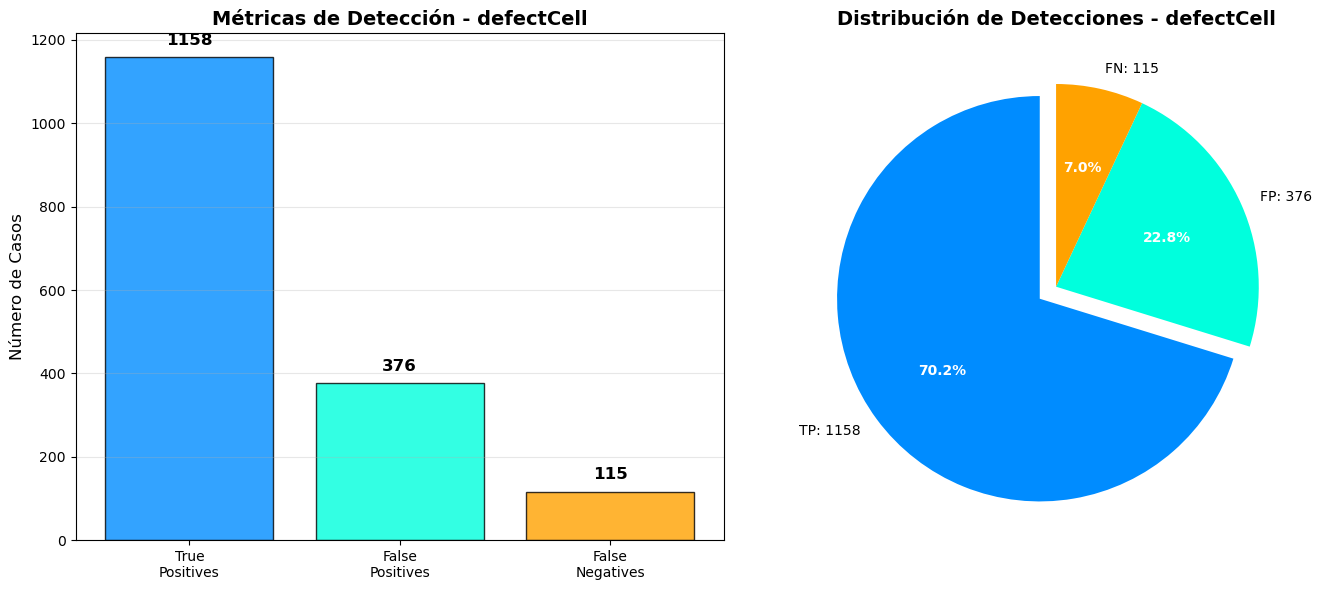

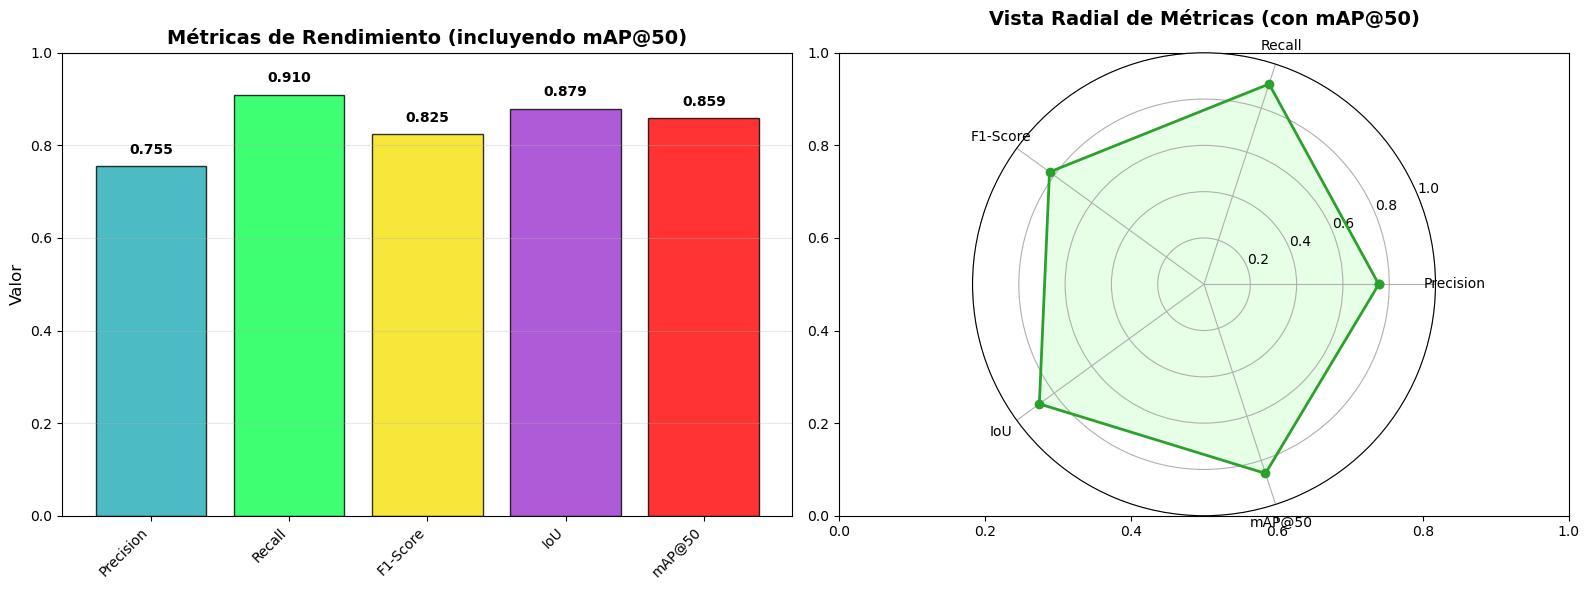


Se guardaron las imágenes en ../03.Datasets/Evaluacion_Empresa/DEFAULT/kfold_RCNN
Leyenda: Cajas VERDES = Ground Truth, Cajas ROJAS = Predicciones


In [13]:
# Evaluar en test con métricas
trainer.evaluate_test(
    test_loader=test_loader,
    test_dataset=test_ds,
    weights_model="./Fast_RCNN_models/kfold_best_model.pth",
    confidence_threshold=0.85,
    iou_threshold=0.6,
    save_images=True,
    output_path="../03.Datasets/Evaluacion_Empresa/DEFAULT/kfold_RCNN"
)

---------------------------------------------------------------------------------------------------------------------------------------

In [5]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
            return True
            
        if score > self.best_score + self.delta:
            self.best_score = score
            self.counter = 0
            return True
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            return False


def train_model(model, optimizer, lr_scheduler, num_epochs, train_loader, val_loader, device):

    early_stopping = EarlyStopping(patience=3, delta=0.01)
    train_losses = []
    val_accuracies = []
    for epoch in range(num_epochs):
        print("============================================================================")
        model.train()
        total_loss = 0.0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        
        for images, targets in progress_bar:
            if images is None or targets is None:
                continue
            
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

            del loss_dict, loss
            torch.cuda.empty_cache()
            gc.collect()
                 
        lr_scheduler.step()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Training Loss: {avg_loss:.4f}")

        acc, preds, gts, f1_macro = evaluate_model(model, val_loader, device, CLASS_NAMES)
        val_accuracies.append(acc)

        improved = early_stopping(f1_macro)
        if early_stopping.early_stop:
            print(f"Early stopping triggered. Best F1: {early_stopping.best_score:.4f}")
            break
        elif improved:
            print(f"Model improved. New best F1: {f1_macro:.4f}")
            torch.save(model.state_dict(), ".\\Fast_RCNN_models\\best_model.pth")
        else:
            print(f"No improvement in F1. Patience: {early_stopping.counter}/{early_stopping.patience}")
            
    plot_metrics(train_losses, val_accuracies)
    plot_confusion_matrix(preds, gts, class_names=CLASS_NAMES)


def evaluate_model(model, val_loader, device, class_names, iou_threshold=0.7):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc="Evaluating"):
            if not images or not targets:
                continue

            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)

            for output, target in zip(outputs, targets):
                scores = output['scores'].cpu()
                pred_boxes = output['boxes'].cpu()
                pred_labels = output['labels'].cpu()

                keep = scores > 0.7
                pred_boxes = pred_boxes[keep]
                pred_labels = pred_labels[keep]

                true_boxes = target['boxes'].cpu()
                true_labels = target['labels'].cpu()

                for tb, tl in zip(true_boxes, true_labels):
                    tl_item = tl.item()
                    # Un solo punto de decisión claro para cada objeto verdadero
                    if pred_boxes.shape[0] == 0:
                        # No hay detecciones o match
                        all_preds.append(0)  # Es background
                        all_targets.append(tl_item)
                        continue

                    ious = torchvision.ops.box_iou(tb.unsqueeze(0), pred_boxes)

                    if ious.numel() == 0:
                        all_preds.append(0)  # Es background
                        all_targets.append(tl_item)
                        continue

                    max_iou, max_idx = ious.max(dim=1)
                    pred_label = pred_labels[max_idx].item()
                    
                    # Solo un punto de adición de predicciones - sin duplicaciones
                    if max_iou.item() > iou_threshold:
                        all_preds.append(pred_label)
                        if pred_label == tl_item:
                            correct += 1
                    else:
                        all_preds.append(0)  # Es background si IoU bajo
                    
                    # Siempre agregamos el target una sola vez
                    all_targets.append(tl_item)
                
                total += len(true_boxes)

    accuracy = correct / total if total > 0 else 0

    valid_labels, valid_names = print_classification_report(all_targets, all_preds, class_names)
    
    f1_macro = f1_score(all_targets, all_preds, average='macro', labels=valid_labels)

    return accuracy, all_preds, all_targets, f1_macro


def evaluate_on_test(save_images, score, weights_model, output_path):
    # Crear directorio de salida si no existe
    if save_images:
        os.makedirs(output_path, exist_ok=True)
        print(f"Guardando imágenes en: {output_path}")
    
    # Cargar el mejor modelo de k-fold
    weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
    best_model = fasterrcnn_resnet50_fpn_v2(weights=weights)
    
    in_features = best_model.roi_heads.box_predictor.cls_score.in_features
    best_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(CLASS_NAMES))
    
    # Cargar los pesos del mejor modelo
    try:
        best_model.load_state_dict(torch.load(weights_model))
        print("Modelo K-Fold cargado correctamente")
    except Exception as e:
        print(f"Error al cargar el modelo: {e}")
        return
    
    best_model.to(device)
    best_model.eval()
    
    # Evaluar en el conjunto de prueba y guardar imágenes
    print("\n=== Evaluación del modelo K-Fold en conjunto de prueba ===")
    
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(tqdm(test_loader, desc="Evaluando y guardando imágenes")):
            if not images or not targets:
                continue

            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = best_model(images)

            for i, (output, target) in enumerate(zip(outputs, targets)):
                scores = output['scores'].cpu()
                pred_boxes = output['boxes'].cpu()
                pred_labels = output['labels'].cpu()

                # Filtrar predicciones con confianza > 0.6
                keep = scores > score
                pred_boxes = pred_boxes[keep]
                pred_labels = pred_labels[keep]

                true_boxes = target['boxes'].cpu()
                true_labels = target['labels'].cpu()

                # Procesar para métricas
                for tb, tl in zip(true_boxes, true_labels):
                    tl_item = tl.item()
                    if pred_boxes.shape[0] == 0:
                        all_preds.append(0)
                        all_targets.append(tl_item)
                        continue

                    ious = torchvision.ops.box_iou(tb.unsqueeze(0), pred_boxes)
                    if ious.numel() == 0:
                        all_preds.append(0)
                        all_targets.append(tl_item)
                        continue

                    max_iou, max_idx = ious.max(dim=1)
                    pred_label = pred_labels[max_idx].item()

                    if max_iou.item() > 0.75:
                        all_preds.append(pred_label)
                        if pred_label == tl_item:
                            correct += 1
                    else:
                        all_preds.append(0)

                    all_targets.append(tl_item)

                total += len(true_boxes)
                
                # Guardar imagen con bounding boxes si está habilitado
                if save_images:
                    # Obtener el nombre original del archivo de la imagen
                    img_idx = batch_idx * test_loader.batch_size + i
                    if img_idx < len(test_ds):
                        # Obtener el ID de la imagen desde el dataset
                        img_id = test_ds.ids[img_idx]
                        # Buscar el filename en la información de imágenes del COCO dataset
                        img_info = test_ds.coco.loadImgs(img_id)[0]
                        original_filename = img_info['file_name']
                        # Usar el nombre original pero agregar prefijo de evaluación
                        filename = f"eval_{original_filename}"
                    else:
                        # Fallback en caso de error
                        filename = f"eval_image_{batch_idx}_{i}.jpg"
                    
                    # Convertir imagen a formato uint8
                    img_tensor = (images[i].detach().cpu() * 255).to(torch.uint8)
                    
                    # Dibujar ground truth boxes en verde
                    img_with_gt = draw_bounding_boxes(
                        img_tensor,
                        boxes=true_boxes,
                        colors="green",
                        width=4
                    )
                    
                    # Dibujar predicciones en rojo
                    if pred_boxes.shape[0] > 0:
                        img_with_both = draw_bounding_boxes(
                            img_with_gt,
                            boxes=pred_boxes,
                            colors="red",
                            width=2
                        )
                    else:
                        img_with_both = img_with_gt
                    
                    # Convertir a PIL y guardar
                    pil_img = F.to_pil_image(img_with_both)
                    filepath = os.path.join(output_path, filename)
                    pil_img.save(filepath)

    valid_labels, target_names = print_classification_report(all_targets, all_preds, CLASS_NAMES)
    
    if 1 in valid_labels:
        f1_macro = f1_score(all_targets, all_preds, average='macro', labels=[1])
        print(f"Test F1 Score (macro) para defCell: {f1_macro:.4f}")
    else:
        f1_macro = 0
        print("No hay instancias de defCell para calcular F1")
    
    plot_confusion_matrix(all_preds, all_targets, class_names=target_names)

    if save_images:
        print(f"\nSe guardaron las imágenes en {output_path}")
        print("Leyenda: Cajas VERDES = Ground Truth, Cajas ROJAS = Predicciones")
    
    return 


def print_classification_report(all_targets, all_preds, class_names):
    # Obtener etiquetas únicas presentes
    unique_targets = set(all_targets)
    unique_preds = set(all_preds)
    present_labels = sorted(list(unique_targets.union(unique_preds)))
    
    # Filtrar solo etiquetas válidas
    target_names = []
    valid_labels = []
    
    for label in present_labels:
        if 0 <= label < len(class_names):
            target_names.append(class_names[label])
            valid_labels.append(label)
    
    # Generar reporte
    report = classification_report(
        all_targets, all_preds,
        target_names=target_names,
        labels=valid_labels,
        zero_division=0
    )
    
    print("\nClassification Report:\n", report)
    
    return valid_labels, target_names


def plot_metrics(train_losses, val_accuracies):
    epochs = range(1, len(train_losses)+1)
    
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, marker='o', color='orange')
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(all_preds, all_targets, class_names):
    cm = confusion_matrix(all_targets, all_preds, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)  
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

Epoch 1/5: 100%|██████████| 280/280 [04:13<00:00,  1.11batch/s, loss=0.385] 


Training Loss: 0.4437


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  2.98it/s]



Classification Report:
               precision    recall  f1-score   support

  background       0.00      0.00      0.00         0
  defectCell       1.00      0.85      0.92       879

    accuracy                           0.85       879
   macro avg       0.50      0.42      0.46       879
weighted avg       1.00      0.85      0.92       879

Model improved. New best F1: 0.4584


Epoch 2/5: 100%|██████████| 280/280 [04:08<00:00,  1.13batch/s, loss=0.198] 


Training Loss: 0.2537


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  2.97it/s]



Classification Report:
               precision    recall  f1-score   support

  background       0.00      0.00      0.00         0
  defectCell       1.00      0.88      0.94       879

    accuracy                           0.88       879
   macro avg       0.50      0.44      0.47       879
weighted avg       1.00      0.88      0.94       879

No improvement in F1. Patience: 1/3


Epoch 3/5: 100%|██████████| 280/280 [04:09<00:00,  1.12batch/s, loss=0.245] 


Training Loss: 0.2115


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  2.98it/s]



Classification Report:
               precision    recall  f1-score   support

  background       0.00      0.00      0.00         0
  defectCell       1.00      0.86      0.93       879

    accuracy                           0.86       879
   macro avg       0.50      0.43      0.46       879
weighted avg       1.00      0.86      0.93       879

No improvement in F1. Patience: 2/3


Epoch 4/5: 100%|██████████| 280/280 [04:08<00:00,  1.13batch/s, loss=0.317] 


Training Loss: 0.1814


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  2.97it/s]



Classification Report:
               precision    recall  f1-score   support

  background       0.00      0.00      0.00         0
  defectCell       1.00      0.85      0.92       879

    accuracy                           0.85       879
   macro avg       0.50      0.43      0.46       879
weighted avg       1.00      0.85      0.92       879

Early stopping triggered. Best F1: 0.4584


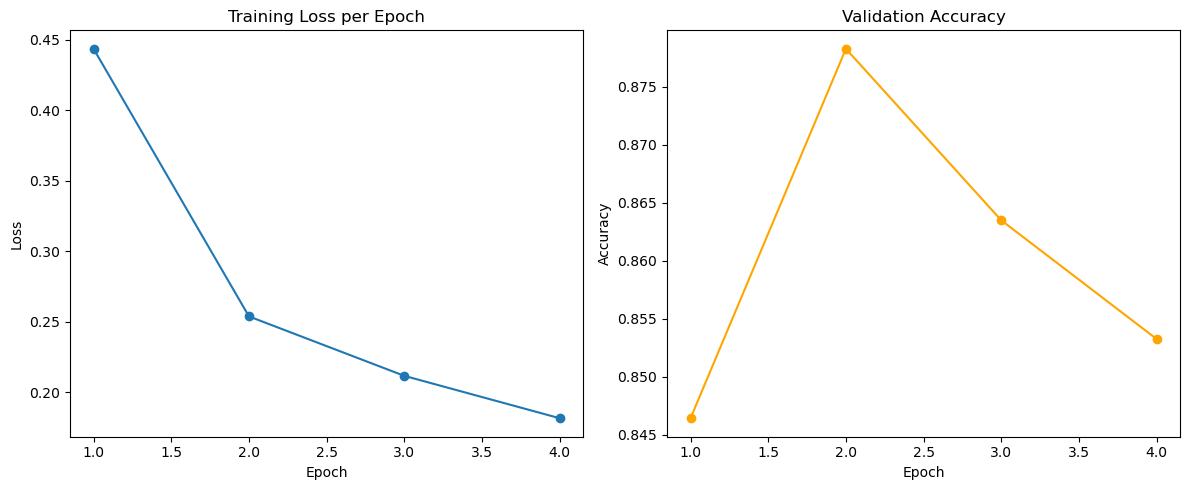

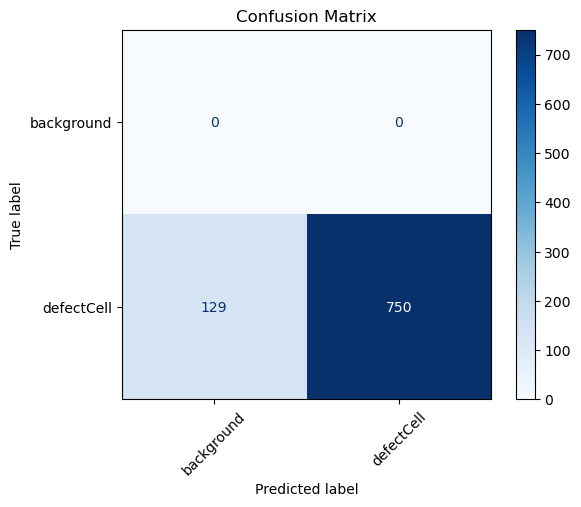

In [8]:
NUM_EPOCH = 5
train_model(model, optimizer, lr_scheduler, NUM_EPOCH, train_loader, val_loader, device)

Guardando imágenes en: ..\03.Datasets\Evaluacion_Empresa\DEFAULT\RCNN
Modelo K-Fold cargado correctamente

=== Evaluación del modelo K-Fold en conjunto de prueba ===


Evaluando y guardando imágenes: 100%|██████████| 87/87 [00:35<00:00,  2.48it/s]


Classification Report:
               precision    recall  f1-score   support

  background       0.00      0.00      0.00         0
  defectCell       1.00      0.82      0.90      1273

    accuracy                           0.82      1273
   macro avg       0.50      0.41      0.45      1273
weighted avg       1.00      0.82      0.90      1273

Test F1 Score (macro) para defCell: 0.8983


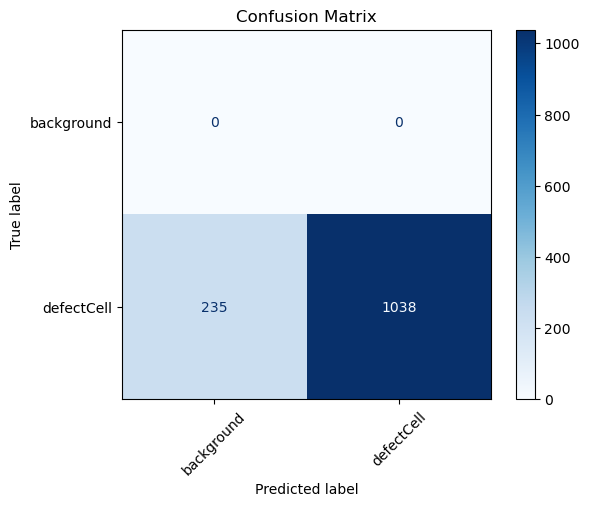


Se guardaron las imágenes en ..\03.Datasets\Evaluacion_Empresa\DEFAULT\RCNN
Leyenda: Cajas VERDES = Ground Truth, Cajas ROJAS = Predicciones


In [9]:
evaluate_on_test(
    save_images=True, 
    score = 0.7,
    weights_model = "./Fast_RCNN_models/best_model.pth",
    output_path="..\\03.Datasets\\Evaluacion_Empresa\\DEFAULT\\RCNN"
)

Importante mantener lo de antes porque si vemos que tras las anotaciones de anomalias mejora, esto ya tenemos que dar respuesta.

El código está bien, cambiar los parámetros del modelo e hiperparámetros y posteriormente hacer una clase que englobe todo este entrenamiento de modo que solo le pasemos el modelo y los parámetros como argumentos de entrada. Este es el modelo que mejores resultados nos ha reportado. no se si podremos probar con rcnn101

## **K-fold**

In [9]:
def run_kfold_cv(k=5, num_epochs=3):
    # Asegurar que existe el directorio para guardar los modelos
    os.makedirs("./Fast_RCNN_models", exist_ok=True)
    
    # Combinar los datasets
    combined_ds = torch.utils.data.ConcatDataset([train_ds, val_ds])
    
    # Preparar índices para k-fold
    indices = list(range(len(combined_ds)))
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    # Para almacenar resultados
    fold_results = []
    best_f1 = 0
    best_model_state = None
    
    # Ejecutar entrenamiento para cada fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(indices)):
        print(f"\n{'='*60}\nFold {fold+1}/{k}\n{'='*60}")
        
        # Convertir índices de NumPy a Python int
        train_idx = [int(i) for i in train_idx]  
        val_idx = [int(i) for i in val_idx]     
        
        # Crear subconjuntos para este fold
        train_subset = torch.utils.data.Subset(combined_ds, train_idx)
        val_subset = torch.utils.data.Subset(combined_ds, val_idx)
        
        fold_train_loader = DataLoader(train_subset, batch_size=1, 
                                       shuffle=True, collate_fn=collate_fn)
        fold_val_loader = DataLoader(val_subset, batch_size=1, 
                                     shuffle=False, collate_fn=collate_fn)
        
        # Inicializar nuevo modelo para cada fold
        weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
        model_fold = fasterrcnn_resnet50_fpn_v2(weights=weights)
        
        in_features = model_fold.roi_heads.box_predictor.cls_score.in_features
        model_fold.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(CLASS_NAMES))
        model_fold.to(device)
        
        # Configurar optimizador y scheduler
        optimizer = optim.SGD(model_fold.parameters(), lr=0.001, momentum=0.7, weight_decay=0.0005)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
        
        # Entrenar el modelo para este fold
        early_stopping = EarlyStopping(patience=3, delta=0.01)
        train_losses = []
        val_accuracies = []
        
        for epoch in range(num_epochs):
            model_fold.train()
            total_loss = 0.0
            
            progress_bar = tqdm(fold_train_loader, 
                                desc=f"Fold {fold+1}, Epoch {epoch+1}/{num_epochs}", 
                                unit="batch")
            
            # Bucle de entrenamiento
            for images, targets in progress_bar:
                if images is None or targets is None:
                    continue
                
                images = list(img.to(device) for img in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                
                loss_dict = model_fold(images, targets)
                loss = sum(loss for loss in loss_dict.values())
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                progress_bar.set_postfix(loss=loss.item())
                
                # Liberar memoria
                del loss_dict, loss
                torch.cuda.empty_cache()
                gc.collect()
            
            lr_scheduler.step()
            avg_loss = total_loss / len(fold_train_loader)
            train_losses.append(avg_loss)
            
            # Validación después de cada época
            print(f"Validación después de la época {epoch+1}")
            acc, preds, gts, f1_macro = evaluate_model(model_fold, fold_val_loader, device, CLASS_NAMES)
            val_accuracies.append(acc)
            
            # Early stopping
            improved = early_stopping(f1_macro)
            if early_stopping.early_stop:
                print(f"Early stopping activado. Mejor F1: {early_stopping.best_score:.4f}")
                break
            elif improved:
                print(f"Modelo mejorado. Nuevo mejor F1: {f1_macro:.4f}")
                torch.save(model_fold.state_dict(), f"./Fast_RCNN_models/fold_{fold+1}_best.pth")
                
                if f1_macro > best_f1:
                    best_f1 = f1_macro
                    best_model_state = model_fold.state_dict()
        
        fold_results.append({
            'fold': fold+1,
            'accuracy': acc,
            'f1_macro': f1_macro
        })
        
        # Visualizar métricas
        plot_metrics(train_losses, val_accuracies)
        plot_confusion_matrix(preds, gts, class_names=CLASS_NAMES)
        
        # Liberar memoria
        del model_fold, optimizer, lr_scheduler
        torch.cuda.empty_cache()
        gc.collect()
    
    # Mostrar resultados de todos los folds
    print("\n==== Resultados de K-Fold Cross Validation ====")
    all_accuracies = [res['accuracy'] for res in fold_results]
    all_f1s = [res['f1_macro'] for res in fold_results]
    
    print(f"Precisión media: {np.mean(all_accuracies):.4f} ± {np.std(all_accuracies):.4f}")
    print(f"F1 Score medio: {np.mean(all_f1s):.4f} ± {np.std(all_f1s):.4f}")
    
    for res in fold_results:
        print(f"Fold {res['fold']}: Precisión={res['accuracy']:.4f}, F1={res['f1_macro']:.4f}")
    
    if best_model_state is not None:
        torch.save(best_model_state, "./Fast_RCNN_models/kfold_best_model.pth")
    
    return fold_results, best_f1


Fold 1/5


Fold 1, Epoch 1/3: 100%|██████████| 280/280 [04:12<00:00,  1.11batch/s, loss=0.183] 


Validación después de la época 1


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  2.97it/s]



Classification Report:
               precision    recall  f1-score   support

  background       0.00      0.00      0.00         0
  defectCell       1.00      0.84      0.91      1073

    accuracy                           0.84      1073
   macro avg       0.50      0.42      0.46      1073
weighted avg       1.00      0.84      0.91      1073

Modelo mejorado. Nuevo mejor F1: 0.4559


Fold 1, Epoch 2/3: 100%|██████████| 280/280 [04:12<00:00,  1.11batch/s, loss=0.305] 


Validación después de la época 2


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  2.97it/s]



Classification Report:
               precision    recall  f1-score   support

  background       0.00      0.00      0.00         0
  defectCell       1.00      0.86      0.92      1073

    accuracy                           0.86      1073
   macro avg       0.50      0.43      0.46      1073
weighted avg       1.00      0.86      0.92      1073



Fold 1, Epoch 3/3: 100%|██████████| 280/280 [04:10<00:00,  1.12batch/s, loss=0.244] 


Validación después de la época 3


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  2.96it/s]



Classification Report:
               precision    recall  f1-score   support

  background       0.00      0.00      0.00         0
  defectCell       1.00      0.84      0.92      1073

    accuracy                           0.84      1073
   macro avg       0.50      0.42      0.46      1073
weighted avg       1.00      0.84      0.92      1073



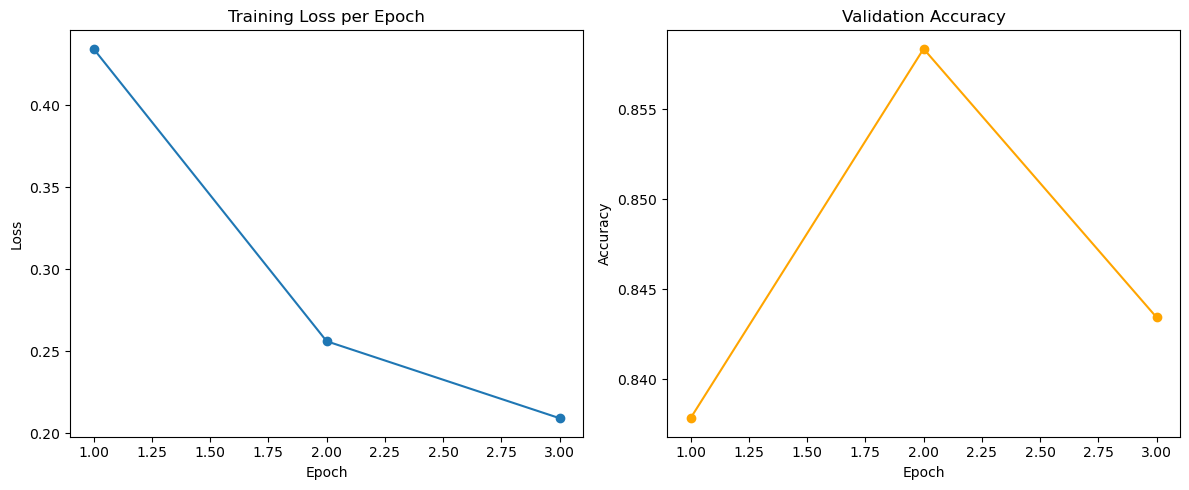

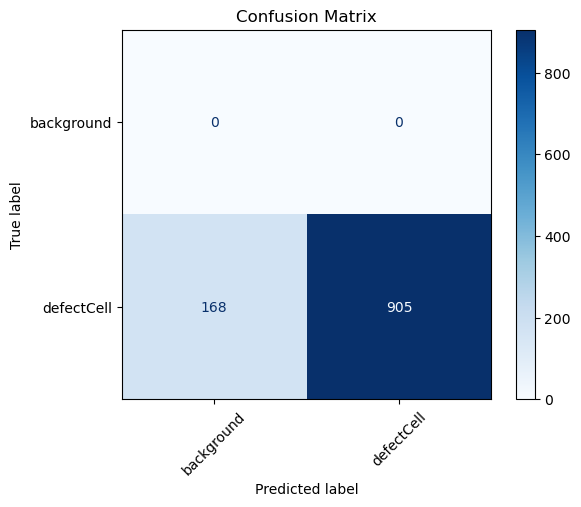


Fold 2/5


Fold 2, Epoch 1/3: 100%|██████████| 280/280 [04:11<00:00,  1.11batch/s, loss=0.427] 


Validación después de la época 1


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  2.96it/s]



Classification Report:
               precision    recall  f1-score   support

  background       0.00      0.00      0.00         0
  defectCell       1.00      0.85      0.92      1156

    accuracy                           0.85      1156
   macro avg       0.50      0.43      0.46      1156
weighted avg       1.00      0.85      0.92      1156

Modelo mejorado. Nuevo mejor F1: 0.4603


Fold 2, Epoch 2/3: 100%|██████████| 280/280 [04:12<00:00,  1.11batch/s, loss=0.141] 


Validación después de la época 2


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  2.96it/s]



Classification Report:
               precision    recall  f1-score   support

  background       0.00      0.00      0.00         0
  defectCell       1.00      0.87      0.93      1156

    accuracy                           0.87      1156
   macro avg       0.50      0.43      0.46      1156
weighted avg       1.00      0.87      0.93      1156



Fold 2, Epoch 3/3: 100%|██████████| 280/280 [04:12<00:00,  1.11batch/s, loss=0.183] 


Validación después de la época 3


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  2.95it/s]



Classification Report:
               precision    recall  f1-score   support

  background       0.00      0.00      0.00         0
  defectCell       1.00      0.88      0.94      1156

    accuracy                           0.88      1156
   macro avg       0.50      0.44      0.47      1156
weighted avg       1.00      0.88      0.94      1156



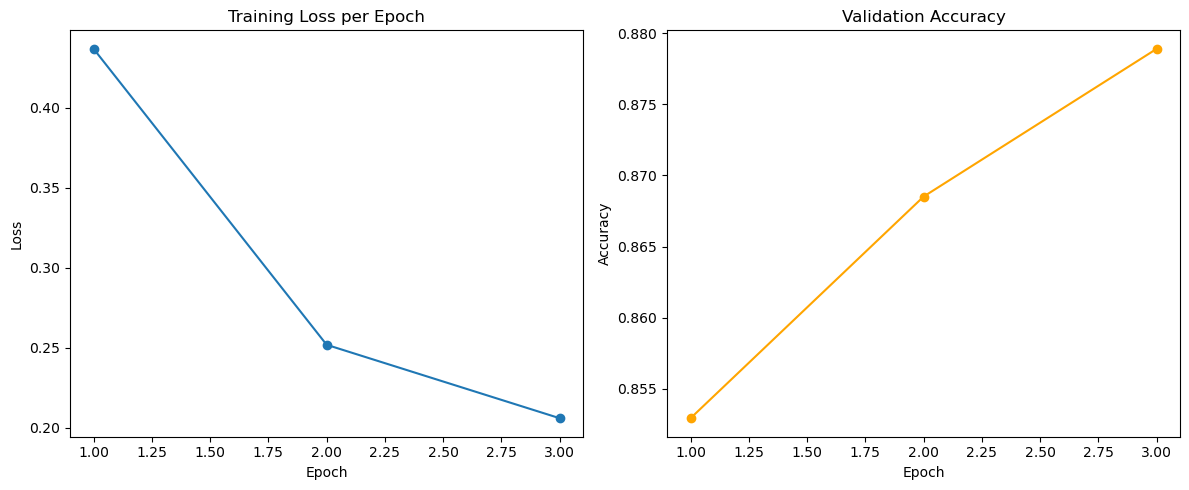

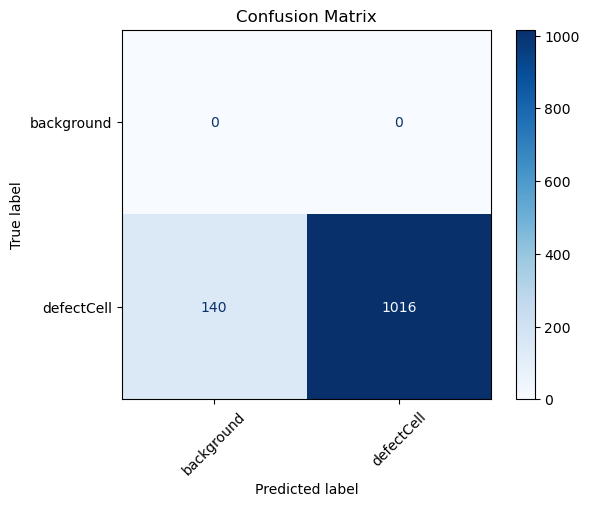


Fold 3/5


Fold 3, Epoch 1/3: 100%|██████████| 280/280 [04:12<00:00,  1.11batch/s, loss=0.183]


Validación después de la época 1


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  2.98it/s]



Classification Report:
               precision    recall  f1-score   support

  background       0.00      0.00      0.00         0
  defectCell       1.00      0.84      0.91       829

    accuracy                           0.84       829
   macro avg       0.50      0.42      0.46       829
weighted avg       1.00      0.84      0.91       829

Modelo mejorado. Nuevo mejor F1: 0.4560


Fold 3, Epoch 2/3: 100%|██████████| 280/280 [04:12<00:00,  1.11batch/s, loss=0.31]  


Validación después de la época 2


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  2.92it/s]



Classification Report:
               precision    recall  f1-score   support

  background       0.00      0.00      0.00         0
  defectCell       1.00      0.86      0.92       829

    accuracy                           0.86       829
   macro avg       0.50      0.43      0.46       829
weighted avg       1.00      0.86      0.92       829



Fold 3, Epoch 3/3: 100%|██████████| 280/280 [04:10<00:00,  1.12batch/s, loss=0.0837]


Validación después de la época 3


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  2.99it/s]



Classification Report:
               precision    recall  f1-score   support

  background       0.00      0.00      0.00         0
  defectCell       1.00      0.85      0.92       829

    accuracy                           0.85       829
   macro avg       0.50      0.43      0.46       829
weighted avg       1.00      0.85      0.92       829



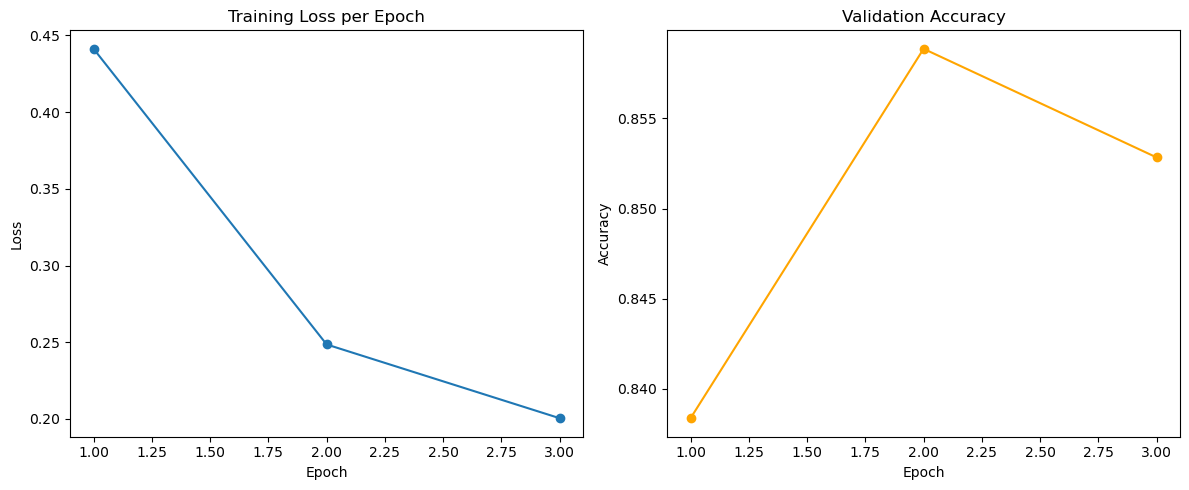

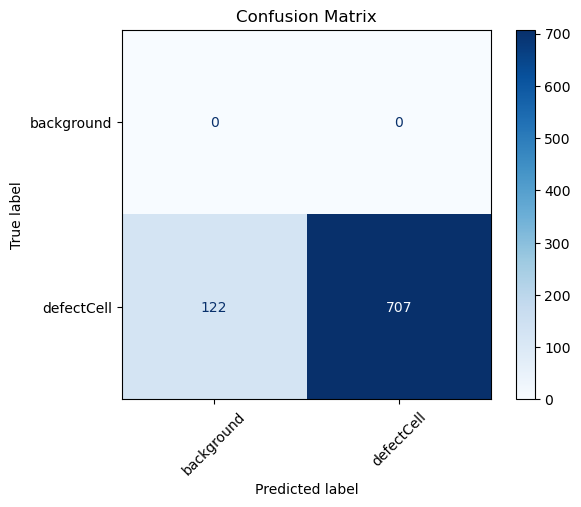


Fold 4/5


Fold 4, Epoch 1/3: 100%|██████████| 280/280 [04:19<00:00,  1.08batch/s, loss=0.193] 


Validación después de la época 1


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  2.98it/s]



Classification Report:
               precision    recall  f1-score   support

  background       0.00      0.00      0.00         0
  defectCell       1.00      0.87      0.93       910

    accuracy                           0.87       910
   macro avg       0.50      0.43      0.46       910
weighted avg       1.00      0.87      0.93       910

Modelo mejorado. Nuevo mejor F1: 0.4644


Fold 4, Epoch 2/3: 100%|██████████| 280/280 [04:10<00:00,  1.12batch/s, loss=0.378] 


Validación después de la época 2


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  2.96it/s]



Classification Report:
               precision    recall  f1-score   support

  background       0.00      0.00      0.00         0
  defectCell       1.00      0.87      0.93       910

    accuracy                           0.87       910
   macro avg       0.50      0.43      0.46       910
weighted avg       1.00      0.87      0.93       910



Fold 4, Epoch 3/3: 100%|██████████| 280/280 [04:12<00:00,  1.11batch/s, loss=0.167] 


Validación después de la época 3


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  2.97it/s]



Classification Report:
               precision    recall  f1-score   support

  background       0.00      0.00      0.00         0
  defectCell       1.00      0.88      0.94       910

    accuracy                           0.88       910
   macro avg       0.50      0.44      0.47       910
weighted avg       1.00      0.88      0.94       910



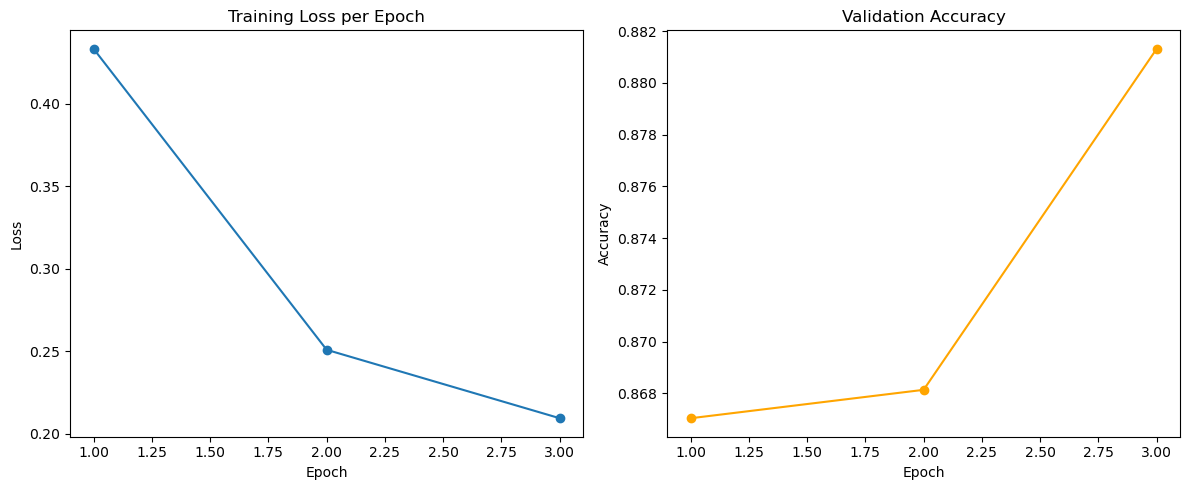

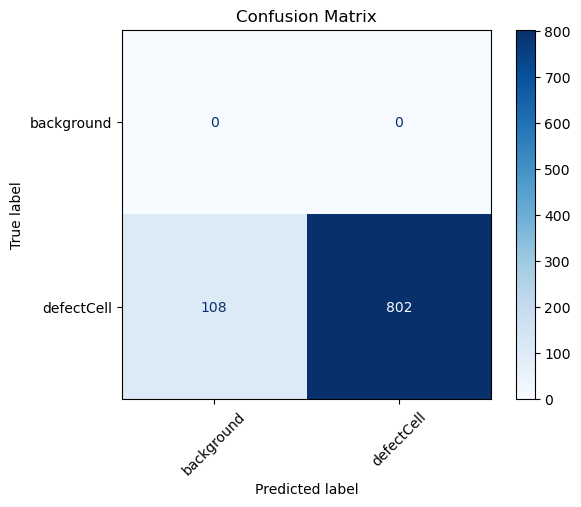


Fold 5/5


Fold 5, Epoch 1/3: 100%|██████████| 280/280 [04:14<00:00,  1.10batch/s, loss=0.223] 


Validación después de la época 1


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  2.96it/s]



Classification Report:
               precision    recall  f1-score   support

  background       0.00      0.00      0.00         0
  defectCell       1.00      0.83      0.91       844

    accuracy                           0.83       844
   macro avg       0.50      0.41      0.45       844
weighted avg       1.00      0.83      0.91       844

Modelo mejorado. Nuevo mejor F1: 0.4530


Fold 5, Epoch 2/3: 100%|██████████| 280/280 [04:13<00:00,  1.10batch/s, loss=0.282] 


Validación después de la época 2


Evaluating: 100%|██████████| 70/70 [00:23<00:00,  2.96it/s]



Classification Report:
               precision    recall  f1-score   support

  background       0.00      0.00      0.00         0
  defectCell       1.00      0.86      0.93       844

    accuracy                           0.86       844
   macro avg       0.50      0.43      0.46       844
weighted avg       1.00      0.86      0.93       844

Modelo mejorado. Nuevo mejor F1: 0.4634


Fold 5, Epoch 3/3: 100%|██████████| 280/280 [04:17<00:00,  1.09batch/s, loss=0.221] 


Validación después de la época 3


Evaluating: 100%|██████████| 70/70 [00:24<00:00,  2.90it/s]



Classification Report:
               precision    recall  f1-score   support

  background       0.00      0.00      0.00         0
  defectCell       1.00      0.83      0.91       844

    accuracy                           0.83       844
   macro avg       0.50      0.41      0.45       844
weighted avg       1.00      0.83      0.91       844



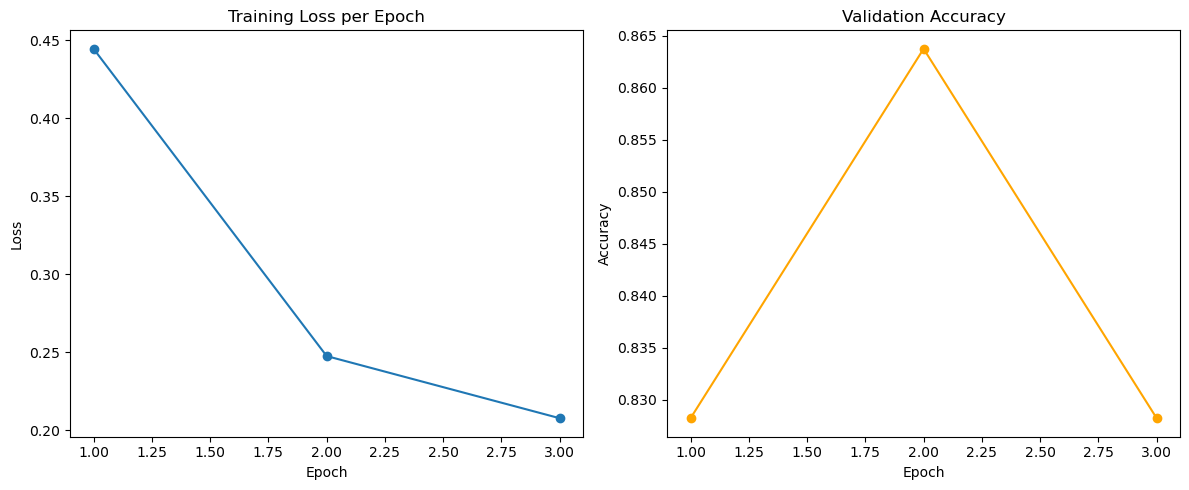

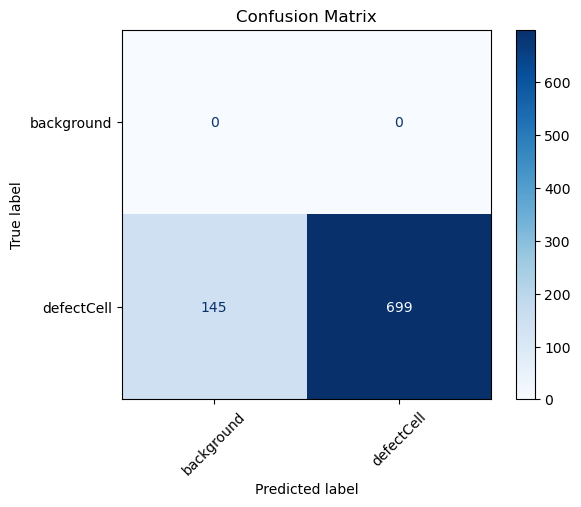


==== Resultados de K-Fold Cross Validation ====
Precisión media: 0.8569 ± 0.0205
F1 Score medio: 0.4614 ± 0.0059
Fold 1: Precisión=0.8434, F1=0.4575
Fold 2: Precisión=0.8789, F1=0.4678
Fold 3: Precisión=0.8528, F1=0.4603
Fold 4: Precisión=0.8813, F1=0.4685
Fold 5: Precisión=0.8282, F1=0.4530


In [10]:
fold_results, best_f1 = run_kfold_cv(k=5, num_epochs=3)

Guardando imágenes en: ..\03.Datasets\Evaluacion_Empresa\DEFAULT\kfold_RCNN
Modelo K-Fold cargado correctamente

=== Evaluación del modelo K-Fold en conjunto de prueba ===


Evaluando y guardando imágenes: 100%|██████████| 87/87 [00:35<00:00,  2.42it/s]


Classification Report:
               precision    recall  f1-score   support

  background       0.00      0.00      0.00         0
  defectCell       1.00      0.87      0.93      1273

    accuracy                           0.87      1273
   macro avg       0.50      0.44      0.47      1273
weighted avg       1.00      0.87      0.93      1273

Test F1 Score (macro) para defCell: 0.9312


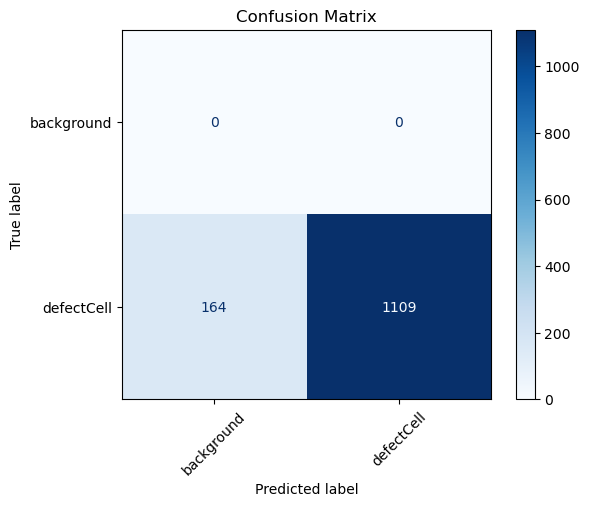


Se guardaron las imágenes en ..\03.Datasets\Evaluacion_Empresa\DEFAULT\kfold_RCNN
Leyenda: Cajas VERDES = Ground Truth, Cajas ROJAS = Predicciones


In [11]:
evaluate_on_test(
    save_images=True, 
    score = 0.7,
    weights_model = "./Fast_RCNN_models/kfold_best_model.pth",
    output_path="..\\03.Datasets\\Evaluacion_Empresa\\DEFAULT\\kfold_RCNN"
)

corrijo esto y me voy a etiquetar los artefactos para tener todo en commits separados